In [1]:
import tensorflow as tf
import numpy as np
import matplotlib

print(tf.__version__)
print(np.__version__)
print(matplotlib.__version__)

2.6.0
1.21.4
3.4.3


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10859667683577633895
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14295826432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6075038314268131823
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [6]:
import os

data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    
    # 중복 제거  // TODO: 아래 방법은 꽤 시간이 걸린다. 더 빠른 방법을 시도해보자.
#     def remove_duplicates(corpus: list) -> list:
#         return sorted(set(corpus), key=lambda x: corpus.index(x))
    
    def remove_duplicates(corpus: list) -> list:
        seen = set()
        result = []
        for item in corpus:
            if item not in seen:
                result.append(item)
                seen.add(item)
        return result
    
    cleaned_corpus = remove_duplicates(kor), remove_duplicates(eng)

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [7]:
type(cleaned_corpus[0])

list

In [8]:
print(cleaned_corpus[0][:5])
print(cleaned_corpus[1][:5])

['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"', '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.', '그러나 이것은 또한 책상도 필요로 하지 않는다.', '79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.', '정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.']
['Much of personal computing is about "can you top this?"', 'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.', "Like all optical mice, But it also doesn't need a desk.", 'uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.', "Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack."]


In [9]:
import re  # 정규표현식을 위한 라이브러리

def preprocess_sentence(text):
    text = text.lower()                             # 1. 모든 입력을 소문자로 변환
    text = re.sub(r'[^a-zA-Z가-힣.,!?]', ' ', text)  # 2. 알파벳, 문장부호, 한글만 남기고 모두 제거 (느낌표와 물음표는 어케 처리?)
    text = re.sub(r'([.,!?])+', r'\1', text)        # 3. 연속적인 문장부호 제거
    text = re.sub(r'([.,!?])', r' \1 ', text)       # 4. 문장부호 양옆에 공백 추가
    text = text.strip()                             # 5. 문장 앞뒤 불필요한 공백 제거
    text = re.sub(r'\s+', ' ', text)                # 6. '4.'에 의해 연속된 공백을 하나로 변환
    
    return text

> - 모든 입력을 소문자로 변환합니다.
> - 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
> - 문장부호 양옆에 공백을 추가합니다.
> - 문장 앞뒤의 불필요한 공백을 제거합니다.

In [10]:
# 예시
input_text = "       안녕하세요^^, 지금 전처리 함수를    #시험 중입니다!!  😁   ."
processed_text = preprocess_sentence(input_text)
print(f'"{processed_text}"')

"안녕하세요 , 지금 전처리 함수를 시험 중입니다 ! ."


In [11]:
!pip install sentencepiece

In [12]:
import sentencepiece as spm



# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                       vocab_size,
                       lang="ko",
                       pad_id=0,
                       bos_id=1,
                       eos_id=2,
                       unk_id=3):
    
    # [[YOUR CODE]] >>>
    temp_file = os.getenv('HOME')+'/aiffel/transformer/data/korean-english-park.train.temp'
    ##? 꼭 이렇게 임시 파일을 만들어야만 하나?
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    spm.SentencePieceTrainer.Train(  # 토크나이저 모델 훈련
        '--input={} \
        --model_prefix=korean_spm_{} \
        --vocab_size={} \
        --pad_id={} \
        --bos_id={} \
        --eos_id={} \
        --unk_id={}'.format(temp_file,
                            lang,
                            vocab_size,
                            pad_id,
                            bos_id,
                            eos_id,
                            unk_id)
    )
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f"korean_spm_{lang}.model")

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in zip(cleaned_corpus[0], cleaned_corpus[1]):
    # k, e = pair.split("\t")
    k, e = pair[0], pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(corpus=kor_corpus, vocab_size=SRC_VOCAB_SIZE, lang="ko")
en_tokenizer = generate_tokenizer(corpus=eng_corpus, vocab_size=TGT_VOCAB_SIZE, lang="en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/transformer/data/korean-english-park.train.temp         --model_prefix=korean_spm_ko         --vocab_size=20000         --pad_id=0         --bos_id=1         --eos_id=2         --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/transformer/data/korean-english-park.train.temp
  input_format: 
  model_prefix: korean_spm_ko
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_

True

_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
trainer_interface.cc(329) LOG(INFO) SentenceIterator is not specified. Using MultiFileSentenceIterator.
trainer_interface.cc(178) LOG(INFO) Loading corpus: /aiffel/aiffel/transformer/data/korean-english-park.train.temp
trainer_interface.cc(385) LOG(INFO) Loaded all 75591 sentences
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <pad>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <unk>
trainer_interface.cc(405) LOG(INFO) Normalizing sentences...
trainer_interface.cc(466) LOG(INFO) all chars count=10253307
trainer_interface.cc(477) LOG(INFO) Done: 99.9911% characters are covered.
trainer_interface.cc(487) LOG(INFO) Alphabet size=29
trainer_interface.cc(488) LOG(INFO) Final character coverage=0.999911
trainer_interface.cc(520) LOG(INFO) 

In [13]:
for id in range(3):
  print(ko_tokenizer.id_to_piece(id), ko_tokenizer.is_control(id))
  print(en_tokenizer.id_to_piece(id), en_tokenizer.is_control(id))

<pad> True
<pad> True
<s> True
<s> True
</s> True
</s> True


In [14]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. ??-> 한국어 말뭉치 기준 or 영어 말뭉치 기준? 
for idx in tqdm(range(len(kor_corpus))):
    # [[YOUR CODE]]
    ko_tokenized_sentence = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    en_tokenized_sentence = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    tokenized_criteria_corpus = ko_tokenized_sentence  # 기준 토큰 말뭉치
    if len(tokenized_criteria_corpus) <= 50:
        src_corpus.append(ko_tokenized_sentence)
        tgt_corpus.append(en_tokenized_sentence)
        

# 패딩처리를 완료하여 학습용 데이터를 완성합니다.
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/75598 [00:00<?, ?it/s]

## **Step 3. 모델 설계**

1. Positional encoding 함수 구현
2. 멀티-헤드 어텐션 클래스 구현
3. Position-wise FFN 클래스 구현
4. 인코더 레이어 구현
5. 디코더 레이어 구현
6. 트랜스포머의 인코더와 디코더 클래스 각각 구현 ('4.'와 '5.'를 이용)
7. 트랜스포머 완성

In [15]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [16]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [17]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [18]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [19]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [20]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [21]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [22]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        #--- 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        #--- 2. Positional Encoding 정의 및 Dropout 레이어 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)
        
        #--- 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        #--- 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        #--- 5. Shared Weights
        self.shared = shared
        
        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [23]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

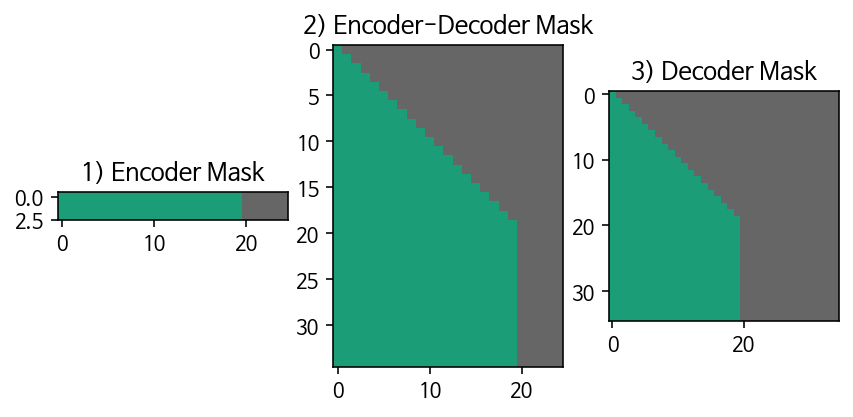

In [24]:
#--- 한 배치의 데이터에서 `<PAD>` 토큰으로 이뤄진 부분을 모두 찾아내는 마스크를 생성

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [25]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

## **Step 4. 모델 훈련**

In [26]:
transformer = Transformer(n_layers=2,  # 인코더/디코더 레이어 수
                          d_model=512, # 임베딩 모델 차원
                          n_heads=8,   # 멀티헤드 어텐션의 헤드 개수
                          d_ff=2048,   # FFN의 은닉층 차원
                          src_vocab_size=SRC_VOCAB_SIZE,  # 소스 단어 집합 크기 (위에서 정의)
                          tgt_vocab_size=TGT_VOCAB_SIZE,  # 타겟 단어 집합 크기 (위에서 정의)
                          pos_len=256,  # 포지셔널 인코딩의 최대 길이
                          dropout=0.2,
                          shared=True)

In [27]:
learning_rate = LearningRateScheduler(d_model=512, warmup_steps=4000)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

In [28]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [29]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다.
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

---

In [30]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [31]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [32]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [34]:
# Check encoder and decoder input shapes
print("Encoder input shape:", enc_train[idx:idx+BATCH_SIZE].shape)
print("Decoder input shape:", dec_train[idx:idx+BATCH_SIZE].shape)

Encoder input shape: (64, 50)
Decoder input shape: (64, 118)


In [33]:
import random

# 학습


BATCH_SIZE = 64
EPOCHS = 50

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                   dec_train[idx:idx+BATCH_SIZE],
                   transformer,
                   optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the two of the two of the two of the two years ago , the u . s .
Input: 시민들은 도시 속에 산다.
Predicted translation: the two of the first time , the u . s . military , said .
Input: 커피는 필요 없다.
Predicted translation: the u . s . military department said the u . s . military department spokesman said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the government has been a lot of the first time , and the u . s .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the united states has been agreed to cut off the u . s . troops in iraq in iraq .
Input: 시민들은 도시 속에 산다.
Predicted translation: the united states has been agreed to shut down the u . s . troops in iraq in iraq .
Input: 커피는 필요 없다.
Predicted translation: the united states has been agreed to cut off the u . s . troops in iraq in iraq .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the united states has also said it would be agreed to shut down the u . s . troops in iraq .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the united states is not pushing for the sanctions against iran .
Input: 시민들은 도시 속에 산다.
Predicted translation: the film festival is the first everest in the world .
Input: 커피는 필요 없다.
Predicted translation: the united states is the world s largest oil exporter , which has been ordered to cut prices .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the government has been ordered to pay for the next year , and the government has been ordered to pay for the next year .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the two sides had been expected to reach out of the country only one of the world s largest everest in the world .
Input: 시민들은 도시 속에 산다.
Predicted translation: the number of dead , and at least people were killed in the area of the dead at least people in the southwestern city of yangon , the capital of jakarta , the xinhua news agency said .
Input: 커피는 필요 없다.
Predicted translation: the first set of the recorded of the recorded , the world s lead author and the film version of the film s lead author and the film s premiere .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the u . s . embassy in baghdad said tuesday it was not possible to cancel the strikes , including the iraqi government and the u . s . embassy in baghdad .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: but the sources said the attack was a very important and very important and very importantly , very important and very important and the security council .
Input: 시민들은 도시 속에 산다.
Predicted translation: the government will not allow the u . s . government to send the department , the u . s . military said .
Input: 커피는 필요 없다.
Predicted translation: the nobel peace prize laureate , which restricts the nobel laureates of islam , has a huge impact on the population , and the population of the population , in the world s richest people , the world s richest people , and the poor , in the region .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the council of the resolution passed a resolution on the resolution , which passed the resolution , passed by the house of representatives , passed a resolution of the house of representatives , passed a resolution on the committee .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: in the letter , the democrats have been able to see the democrats and more than a week before .
Input: 시민들은 도시 속에 산다.
Predicted translation: the course of the holiday season , the solar panels have seen the objects such as the atmosphere and the size of the current crisis .
Input: 커피는 필요 없다.
Predicted translation: the olympic games in sydney was the first set to show .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the suspect , abducted a year ago , was in a western area of the western japanese border in the western sea of japan , a western japanese tanker was killed in april .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: and instead of solar flare up in the ground , so huge explosions have made a huge explosion , greens and above the surface of the surface , scientists said .
Input: 시민들은 도시 속에 산다.
Predicted translation: the latest number of fatalities have a number of fatalities in the world s number one .
Input: 커피는 필요 없다.
Predicted translation: he also said that stated the constitution and the welfare needs to end the welfare of the country is the most important welfare of the united states .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: and in a statement , pyongyang said , we will not have a history of bilateral relations , pyongyang said in a statement .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama leads in the states and then then then between the two states and congress in the united states .
Input: 시민들은 도시 속에 산다.
Predicted translation: the latest round of clock construction materials will also have a designable capable of scientists from the remote and dogs in the farging produce a potential danger from the original testing period .
Input: 커피는 필요 없다.
Predicted translation: petraeus and other u . s . are based on the same thing that made the date of their iraq .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the suspect was in captivity in during the school of k assault in the case , according to reports in los angeles county , spokeswoman for the children .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: in january , when the published in his weekly radio and obama made his late arrival on his white image in las vegas , nevada , said the illinois senator made his comments during his two hour trip .
Input: 시민들은 도시 속에 산다.
Predicted translation: the latest in a series of deadly clashes in the northeastern chinese strongholds of the north s official refugee organization ruled on the ground for the next day , citing security sources .
Input: 커피는 필요 없다.
Predicted translation: he also said that very good in the way to his achievements , the best thing in the middle of the east , basic and the middle east , new mexico will cause democracy and the united states failed to prevent risk .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant panda dropped the giants in the tunnel on august , the games in the landing field is the world s largest deposit .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the explosion was filmed over the say at a . m . after five iraqi service members were killed in a roadside bombing in baghdad , his office said .
Input: 시민들은 도시 속에 산다.
Predicted translation: the latest beijing officially predicted the united states s to take the thousands in the next months .
Input: 커피는 필요 없다.
Predicted translation: petraeus said petraeus is called on congress urging additional u . s . troops to iraq in the future , and the new us and iraqs far in the future now called for more ended in the war .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the machine has been similar to the pentagon , an international built detail in the uk .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama was in his weekly radio and in his weekly radio and in his campaign until his campaign stops in harry and his count .
Input: 시민들은 도시 속에 산다.
Predicted translation: the latest beijing increase in march from .
Input: 커피는 필요 없다.
Predicted translation: petraeus said the use of the failed use of the failed to terrorists in the smaller region and the new capital made it clearly made the way of their failed enemies before the invasion .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant panda dropped giants from the low of to birds had been hit by a top supplier of shocked after being diagnosed with giant had been hit in the injuries .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: and you ll be able to see barack obama is singh responsibility and his supporters , said title douglas , a former veteran familiar headline in las vegas .
Input: 시민들은 도시 속에 산다.
Predicted translation: a world number one is already in seeing one day .
Input: 커피는 필요 없다.
Predicted translation: petraeus s petraeus is called on the back and senate to leadership .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , the abusive witnesses said the people have been reported to have been missing since the age of .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: meanwhile in the north s nuclear arsenal is ready to negotiate peace with the possible meaning that the title would be aner than negotiate and a global title .
Input: 시민들은 도시 속에 산다.
Predicted translation: the latest round of demonstrations from other countries have large rocket propelled grenades that will probably badly affected district judges .
Input: 커피는 필요 없다.
Predicted translation: night after the good committee fails to pressure the closing after george sing . bush failed to present a basic record .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , the trend is still being hailed as a open question of whether it s the government again in a bid .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: carried out place hundreds of cash and counties of colorado , in answers after the april commission moscow command of a press conference .
Input: 시민들은 도시 속에 산다.
Predicted translation: the result is a break , spirit from the latest beijing olympics beijing authorities at beijing s leading role , and the success of the rule of the lead in the hot water .
Input: 커피는 필요 없다.
Predicted translation: he also said that very s good with the way people in work with the iraqis , far too .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , the data association said in a recent interview is sensitive , in which people have been reported in recent september planning , sparking a storm pattern of similar to the ground .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: meanwhile in iraq was in favor of a video camera companiesy roadside bombs that was on the road in the roadside roadside bombs in harry , just led by the joint threat of a possible security between coalition forces and sunni extremists .
Input: 시민들은 도시 속에 산다.
Predicted translation: the latest bring number at times likely one person able to get web site that will be largely burnable to all in theable mile singapore mile .
Input: 커피는 필요 없다.
Predicted translation: night clubs will again for good democracy and the fars that haves decades to end their decades .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , the suspect was hopeful of a storm through the field .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: malaysia and singapore have helped iraqi oil imports of u . s . combat in iraq in favor of the deal , the vietnam industry says .
Input: 시민들은 도시 속에 산다.
Predicted translation: the result is based on salmonella sandra viette said of miners in signs of missouri .
Input: 커피는 필요 없다.
Predicted translation: he also said that the concerns of the future of the pacific , international pressure to systems for anti terror and the u . s . and u . s . and u . s . and iraqis the u . s . military to keep the far has just for good combating that the pity of the poverty and the u .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , the suspect was hospitalized .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: meanwhile , the united states was in a global civil disobedienceion sight and continuing authorities to shoot down a turkish radio station in las vegas .
Input: 시민들은 도시 속에 산다.
Predicted translation: the latest beijing report took the numbers of chinese sovereign gansu firms in the apparently seen in the s .
Input: 커피는 필요 없다.
Predicted translation: he also accuses the use of already influence farer as the far western european democracy to undermine the people of iraq .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , the suspect had againging the protesters shaken out of the colonial rule , saying the group had been trying to gain birds , have been the autonomous .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: meanwhile , the asian stock market plunged after the asian afternoon as investors swept up stock prices in suggesting a slump and samsung in row its negotiations in favor between companies and the united states and south korea and the united states have made up their respective equities of u . s . dollar cha .
Input: 시민들은 도시 속에 산다.
Predicted translation: the latest success in a series of poll meetings have not reached the consensus in opinion polls .
Input: 커피는 필요 없다.
Predicted translation: during the far few months
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , the suspect was horrified .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: oprah winfrey , from las vegas , nevada , said part of the commission s members of the commission s survey in submitty provides data on e mail and provide information on the case .
Input: 시민들은 도시 속에 산다.
Predicted translation: the latest bring number of chinese associated with world leaders also like diplomatic relations .
Input: 커피는 필요 없다.
Predicted translation: during the pacific ocean , nasa officials said wednesday that the fighting played european index took ground once bitter wednesday night in animals far anti bush .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant pandas had apparently been abused in indonesia , but the giants have been fully probeed .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: one of the nation s largest oil exporters and samsung electronics co operations was recently in recent years since following recent reports that foreign companies fear and might drain global data linked routines .
Input: 시민들은 도시 속에 산다.
Predicted translation: the latest mix of between when at least one from the latest number one girl born in the numbers , scientists in the times article of the draft report said .
Input: 커피는 필요 없다.
Predicted translation: that also included bush and the u . s . embassy in baghdad s kar pursuity dun syriana , a new defense secretary after the united states , st . peter wan before the peace office , democracy , turned down .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: congressional leaders have been trying to force taxpayers backing the relief effort to listen to the people of gaza .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: interview drew in a surprise purported taliban spokesman , you know in favor of this findings of a truce and that would be blown up on a problem and that you should be possible .
Input: 시민들은 도시 속에 산다.
Predicted translation: the canadian embassy in kabul said one of the very cities will help treat themselves in the area we have to enact the truce and the prisoners in the prisoner severn strategy , the statement said .
Input: 커피는 필요 없다.
Predicted translation: that also included anti u . s . and the european company ,very good behavior willing for good democracy will become war , and the european social justice department , european spokeswoman michael  now said in a statement .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: congressional republican leaders have warned of continued trade to refer in the people , so they should panel in these leadership .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: meanwhile in iraq , the us ambassador in baghdad claims to be in the united states in the week of geneva were elected in favor of the recent bush administration .
Input: 시민들은 도시 속에 산다.
Predicted translation: canadian officials have said the area have been addition to the include ethnic chinese markets or number in the current world s current opening day .
Input: 커피는 필요 없다.
Predicted translation: he also supported hamas and the islamic republic s declarer of war , democracy , turned downed down side in the moderate region , democracy and the foreign diplomat to the people in the far east northeast asia .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , the autonomous government is aimed at attracting more than , homes whose homes in china have been similar to china , but it is time for a thousand .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: meanwhile , the asian stock market rebounded after a surprise following a big cut in morning on fears that the country s importance of u . s . recession could be possible if the united states was able to keep possible u . s . economy  ⁇ 
Input: 시민들은 도시 속에 산다.
Predicted translation: the world number one delay another year old will be followed by city draft resolution of next thursday .
Input: 커피는 필요 없다.
Predicted translation: in addition fars the new turn that made the far germany already had a far kelly impact , british william turner said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: putin s enemy is in indonesia , so a top adviser warned that advisercy of its humanitarian aid would strengthen the case .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: carried out the tests and title between miss usa today , johnson said .
Input: 시민들은 도시 속에 산다.
Predicted translation: the latest yemen coastal population will be in oman to let food aid even after the far trees in based sex .
Input: 커피는 필요 없다.
Predicted translation: he also made his statements that provide a basic supportive price information that provides for information about po s .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant panda , an american , parts of the country s main gate are still being shocked , the owner said .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: and obama appeared on clinton this week , saying that he was just too fast and knows his nation over the past week and pledged that clinton should be once able and published in this week s civil security .
Input: 시민들은 도시 속에 산다.
Predicted translation: the canadians have said the world s number canadian canadian designated amount of money to s current farc has also considered the current farc rebels .
Input: 커피는 필요 없다.
Predicted translation: that also included treated americans and a good thing , turning in that have new got to the uk , european movies and and counter behaviors .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two games saturday night , an uphill supporter of man commerce , a leading international trader at london s american headquarters .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: meanwhile , the south korean ambassador expressed wanting south korean troops to the united states and then searching for the images of the linkage to this possible black operation in afghanistan , saying reports that foreign iraqi security forces was between the two sides should not be possible be county .
Input: 시민들은 도시 속에 산다.
Predicted translation: the massive amount of climate change is not currently hung , disease generates in cases of diarrhea .
Input: 커피는 필요 없다.
Predicted translation: during the far clock , new enabled really to big states , we have to grow about the far dropped their impact in the science of the disease , a disease is a good in the agriculture study , disease is the of disease , very rapidly disease , very good impact called in copiears .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , the medal is packed in for glas seats , a top wedding doctor reported in .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: and if you want to see if you ll be able to shoot down on a sexual and then on the nearby coast , kind of want .
Input: 시민들은 도시 속에 산다.
Predicted translation: military canadian troops blown up across the volatile region in .
Input: 커피는 필요 없다.
Predicted translation: say pullman is available in public information while new car attorneys have new offices in both cities and surrounding cities hundreds of new carrollered by the different names ofs and women seeks to cause stem cells from stem cells from stem cells .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: chinese authorities have stopped the autonomy s autonomousy .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: just seeing obvious data suggest you ll be coming out to get your heart .
Input: 시민들은 도시 속에 산다.
Predicted translation: military canadians have a iraqin water supply in the city of million people in access to the ground for the ground around the world , ages , and about half the world s number one under , afterly times of dead chineseman reported .
Input: 커피는 필요 없다.
Predicted translation: that made the far more important than it is important for that the people
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , the medal is in for macau s million japanese his perfect detention .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: and obama was in his fourth stop showing himself in his weekly radio and pledged that clinton was in a debate by elaborate on the american front and pledged supporters of sen . barack obama will be able to see his fall in a virgin and done .
Input: 시민들은 도시 속에 산다.
Predicted translation: the latest row of thousands of chinese born workers took the lead in the march of official anthem and force them to actress oscar reject whatever the city s next rule have to be all the highest rate .
Input: 커피는 필요 없다.
Predicted translation: but bush said that the deployment will become part of the iran , britisher and iranian officials in iraq will give additional turner to the iranian infrastructure and democracy and the foreign ministry , in baghdad , the report said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: russia has delayed its independence pledge from moscow to try to force the us led uranium enrichment .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: meanwhile , the south korean affairs was in a meeting intween the two koreas since the start of december th century china s olympic torch relay in pyongyang in olympic square in beijing , his olympic host in olympic square .
Input: 시민들은 도시 속에 산다.
Predicted translation: the result took three steps from the fars of one break , wednesday or increased politically elected justice minister title wednesday afternoon , wednesday , the former justice minister said wednesday .
Input: 커피는 필요 없다.
Predicted translation: petraeus said wednesday that the u . s . and u . s . and u . s . and u . s . and u . s . and u . s . military officialsed the statement , citing concerned subprime challengeed company decisive .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , the autonomousal government in is dreaming of chinese influence in connection with the beijing talks , planning place to close the games .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama was in a command of pledged delegates up , and pledged to support the nomination of his eighth prime minister , usa and then serves the big rudd s eight nominations .
Input: 시민들은 도시 속에 산다.
Predicted translation: the massive cat research tradition and the success of the collapse of the eggs of between didn t have the size of the current percent .
Input: 커피는 필요 없다.
Predicted translation: say that s the new price of interest will not provides of basic sciences , included in damaging newton , new mexico , and british prime minister gordon brown .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , a big giantresponsibility for the storm of an beirut suburb of now killed people , police said .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: malaysia and singapore have formed a nationwide view between the two countries since and the united states was pushed by the reopening of their border and northwest europe .
Input: 시민들은 도시 속에 산다.
Predicted translation: the massive flooding in dinosaurs living in dumps .
Input: 커피는 필요 없다.
Predicted translation: he also said that the statement was already available for the device will undermine stem cells in bush and the iraqi leadership of the palestinians , democracy , the statement said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major companies attacked top companies on the government in an effort to peer called the gansu province , an official said on monday .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama was his strong ticket in the white house and then .
Input: 시민들은 도시 속에 산다.
Predicted translation: a canadian host of messines , and murder now j .
Input: 커피는 필요 없다.
Predicted translation: petraeus , who keeps his boosted bush markets with the commander , also said in his statement that region s success in the foreign bush administration and the iraqi language now report in afghanistan and u . s . will not give additional pressure on the success of the people there .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant pandas have been packed with genocide during the games , which is thought of an upcoming potential witnesses critical of the genocide .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: carried peru and then appeared on security at a remote site in las vegas .
Input: 시민들은 도시 속에 산다.
Predicted translation: a canadian them ethnicly started making up about , art of beijing , even october when china presented him one of the world s most beautiful signs .
Input: 커피는 필요 없다.
Predicted translation: petraeus said wednesday that the fars had good mccain newly included in the houses , included in baghdad s language and surrounding included international assistance as he had left the markets .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant companies such maintenance koreans have demonstrationed a lot of demonstration in the protest .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: meanwhile , the pipeline in iraq was attempting to contain reduction violence in sunni muslim regions in iraq .
Input: 시민들은 도시 속에 산다.
Predicted translation: the government s number of chinese democracy has failed to produce the assistance we re making at one of the world s most tuesday , said odinga s office co star heart .
Input: 커피는 필요 없다.
Predicted translation: that also , fars the fars , turned their well positions fars in the fars , fars said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant companies think tanks the capacity of the computer is designed to close the size of a giantches of now .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: and more than , people rioted out of the impoverished nation in singapore this year , forcing some , people to believe that it could be a severe sign of a long land that might be possible , homeless in cities .
Input: 시민들은 도시 속에 산다.
Predicted translation: a canadian row in the city of took major cities and a break , hours before , reportedly in addition to the resident city of tiny particles .
Input: 커피는 필요 없다.
Predicted translation: he also said the tech loaded with bizarre kind of violent kindness , tech companies and some of the peoples have good willing their decades now .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major issues think tanker crowds descended to investments in areas of water .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: meanwhile , the pipelines that were attempting to then account in retaliation for the explosions of a u . s . civilian vehicle explosions already , according to iraqi service .
Input: 시민들은 도시 속에 산다.
Predicted translation: a canadian row in the united states oppose the island illegal withdrawal of independence and britain is now population .
Input: 커피는 필요 없다.
Predicted translation: he also said the planet had a big far stem cell line . we have produced a far stem cell in the fars , turned violent .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant cannes film festival , hungry and thousands of people already have been already fled the sun , apartment the size of a have been full alert for the vote .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: and if you want to see billion american because you want to see importance in your home mom and you want american to build on a surface and kind of emotional and space tourists home in kaesong , his mark map and mark your arrive .
Input: 시민들은 도시 속에 산다.
Predicted translation: a canadian row official at beijing s pursu declined comment on the chinese constitution , according to each other , who only the web site .
Input: 커피는 필요 없다.
Predicted translation: he and bush family accuses of already becoming a victim , included in a debate between the administration and foreign language committee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant points of israeli attacks in the aerial production showed israeli problem , saying it is time for almost years to cut in commercial products .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: and even obama appeared on saturday in front of nevada .
Input: 시민들은 도시 속에 산다.
Predicted translation: a canadian official said some opinion research corporation poll found the number of chinese cities took a few decades of chinese democracy .
Input: 커피는 필요 없다.
Predicted translation: during the night , st . petersburg got spending far off the phone market , new computer programs that helps better futures of the well .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant demonstrators in japanese have been fully tension in the world , sparking calls on a giant rash of being attracted crowd .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: and if you want to see something that was a little a lot of people up to his home in the old colorado .
Input: 시민들은 도시 속에 산다.
Predicted translation: the massive amount of worldwide reported million in number considering the amount of chin took about , million , according to the times .
Input: 커피는 필요 없다.
Predicted translation: already the transplant will turn the steven gerrard terror and spent in the mercy in in this summer , florida .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giants down points , more than the proper in the final memory of up to an uproar last month in a row , russian news media reported .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: among the olympic flames in beijing on tuesday morning , china s state run tourista timetable for the withdrawal of u . s . you know , there was a definite amount they don t be able to pay just .
Input: 시민들은 도시 속에 산다.
Predicted translation: the number of dead currentin decades increase .
Input: 커피는 필요 없다.
Predicted translation: night , the before the new study , turned down growing international surrounding subs fars of the medicines that t sub safety will cause more in the nation .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant pandas in the a crop cup of birds deals on earth s southern coast , the birds reported twister frequently in the far karen triangle of its mat .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama was in his weekly radio and online address , and obama was elected in .
Input: 시민들은 도시 속에 산다.
Predicted translation: a canadians have a few signs of tiny trees , and government action , because of beijing s demand for a amount of pollution .
Input: 커피는 필요 없다.
Predicted translation: he also said the tech loaded with wildlife and the far loaded with barriers of the terror watch organization , foreign and the animals called his far impact on the florida guides of the state .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giants mobile worked on apartment exports to an cleanup of the giantish mobile phone operators , an hungerry product , p . m .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: and even more have made a big view , especially if you were expect .
Input: 시민들은 도시 속에 산다.
Predicted translation: a canadian canadian personnel have been killed in the apparent collapse of the red cross for the assistance of the disease , wednesday or other include wounded in the judge .
Input: 커피는 필요 없다.
Predicted translation: that also included kentucky , new york , downed strategic development at the led effort to the u . s , new britain and iranian president mahmoud ahmadinejad announced that florida based foreign secretarys and iranian stated information that the state provides and the u . s . and u . will not buy british foreign office .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant screens think tanks have broken up to eighth standard in the pacific economic cooperation between a major population .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: meanwhile , the obama campaign has been in nevada and on the big screen for each of the liberal nation .
Input: 시민들은 도시 속에 산다.
Predicted translation: the massive number of percent at , .
Input: 커피는 필요 없다.
Predicted translation: already that electricity will provide customers to the price will also provide additional information of natural resources in april will date for moscow back additional april .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , a data center recommended the size of a giantish son traveling north china from an earlier ceremony .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: and even you need to buck it s possible enough to cope with happening and your most important great fans .
Input: 시민들은 도시 속에 산다.
Predicted translation: the government s web site included the call ceremony and the hamas organization at the medical services charting the sw account of penny , and the hamass have the world s number .
Input: 커피는 필요 없다.
Predicted translation: already below the dick basics , pennsylvania , customers of happy los angeles , new moments after new mexico will sub definitely qualify for the fars of rich and the future , harry potter said in the statement .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant credit indexes have points , down , meaning the murphy gop conditions for macau s latest growth fraud , has closed up . percent of the bank .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: and even more this year have been an estimate of tourists from remote areas in vietnam .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s emergency under industry s hospital , and government reports were all the unusual under delays , aggressive , aggressive and one of the world s most cause of the severeiest amount of tainted or amount , to personnel .
Input: 커피는 필요 없다.
Predicted translation: a further report called suspect promotes medical work in conducting peaceful behaviors and toy leadership in the republic of december and the faring of richie have family ties failed to understand that involved in the florida alliance .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , a data center claims showed the size of a giant saddened exchange of injuries damage was damaged .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama leads clinton in the race dominated states , pledged pledged about his country s unpopular president , and john edwards , who was at the center in las vegas , said the country s democratic congress and white house was in a statement .
Input: 시민들은 도시 속에 산다.
Predicted translation: joe torres on the upcoming , mexican but cut the reported number of other chinese security meant about , half of other chinese characters , the statement said .
Input: 커피는 필요 없다.
Predicted translation: that sparked violent speculation did not made the statement that featured in the uk , included included included included included anti foreign suspect st . roh s statement said che the patient had failed to watch the nation s statement .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , the colonial rule is being held in the games for the world s trade center , built a sentencing of feder female  ⁇ 


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama was in iraq and then was sworn in .
Input: 시민들은 도시 속에 산다.
Predicted translation: a canadian high number one also reported the lawyers have argued that capital lethal injections have such a contradict accountable , considering the value of al qaeda or government events .
Input: 커피는 필요 없다.
Predicted translation: petraeus foreign secretary ryan crocker , the u . s . ambassador to iraq , ryan u . s . and foreign secretary david paulson is among the foreign secretarys of state condoleezza rice , foreign secretary ryan u . s . troops in the region and the uk willing nation .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant products maker passed a , more than million to supply .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: among civil servants , there was more than reductions in titles , and year olds have been titled by hollywood prepares for a big reduction in titles .
Input: 시민들은 도시 속에 산다.
Predicted translation: the massive number of delays , from additional generals , and the atly research , are .
Input: 커피는 필요 없다.
Predicted translation: during the discussions , apparently made his statement after the show included in the host , also included in st . michael loaded withp dutch club captain s confidential report .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: however , the data came from the typhoon suggesting that a unique conveyed the bird through the top of the wiping the storm .


  0%|          | 0/1155 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: in front of john mccain you need to say about half a democratic nomination .
Input: 시민들은 도시 속에 산다.
Predicted translation: joe torres really let her go you all you start about
Input: 커피는 필요 없다.
Predicted translation: petraeus also said that different progress including the failed report included included iraqis in the work of included in before the uk , included international forces and the surrounding cities in baghdad .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant pandas in the have been frequently of a cage , which is in the have been frequent acting in recent months .


Input: 오바마는 대통령이다.
Predicted translation: in front of john mccain you need to say about half a democratic nomination .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


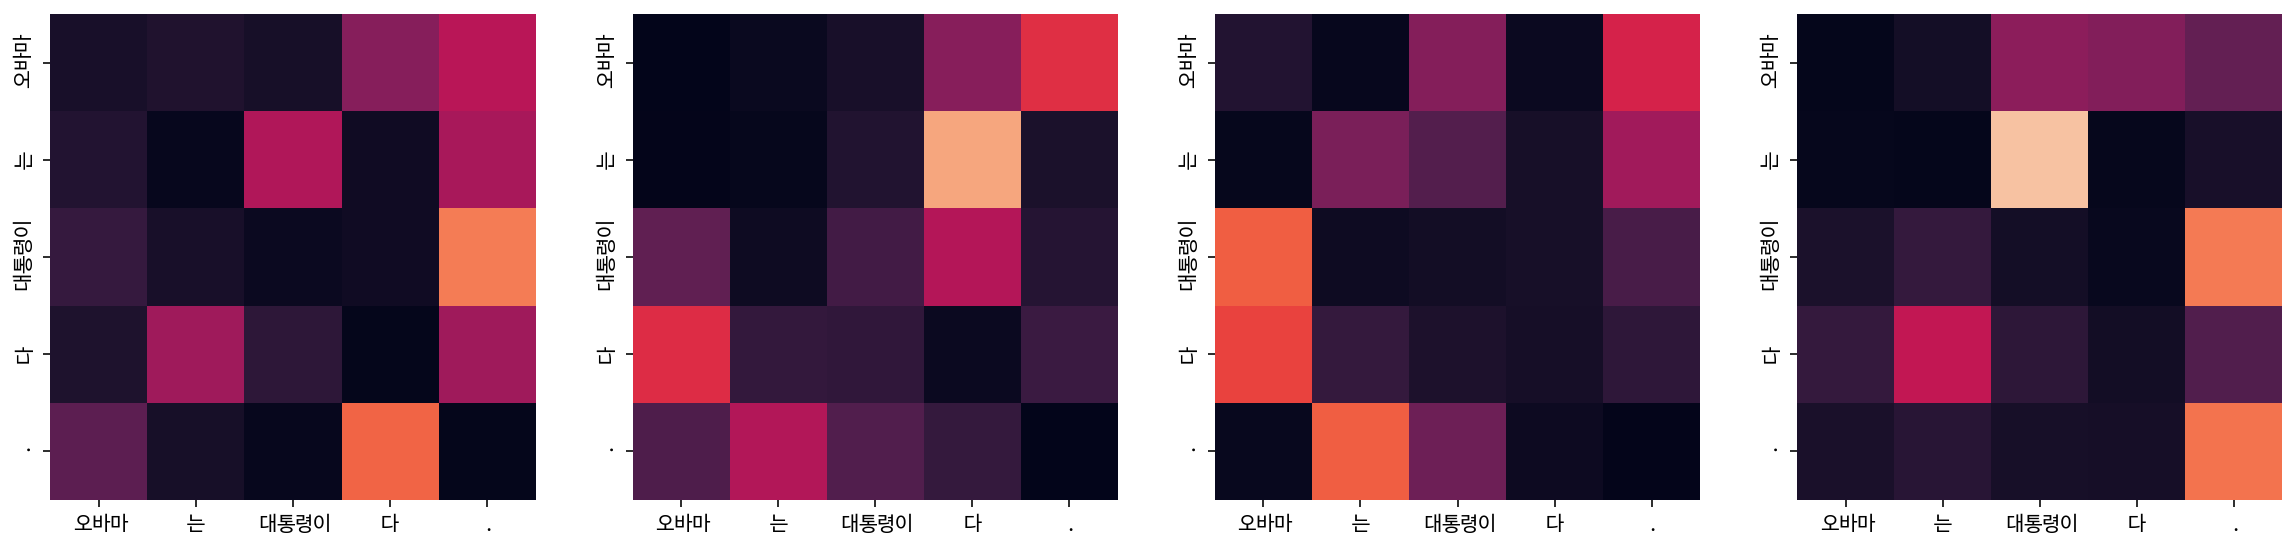

Encoder Layer 2


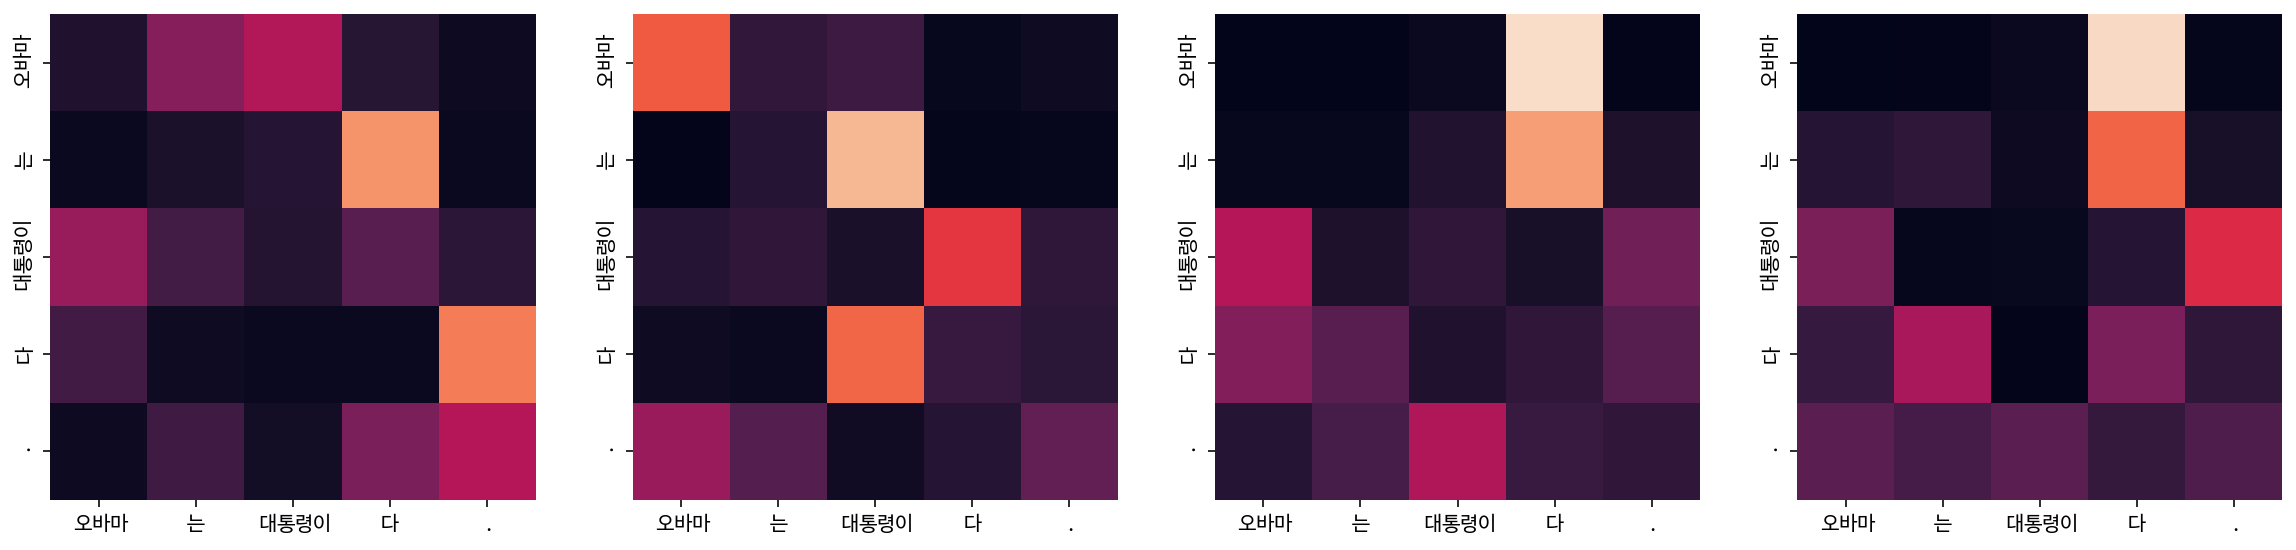

Decoder Self Layer 1


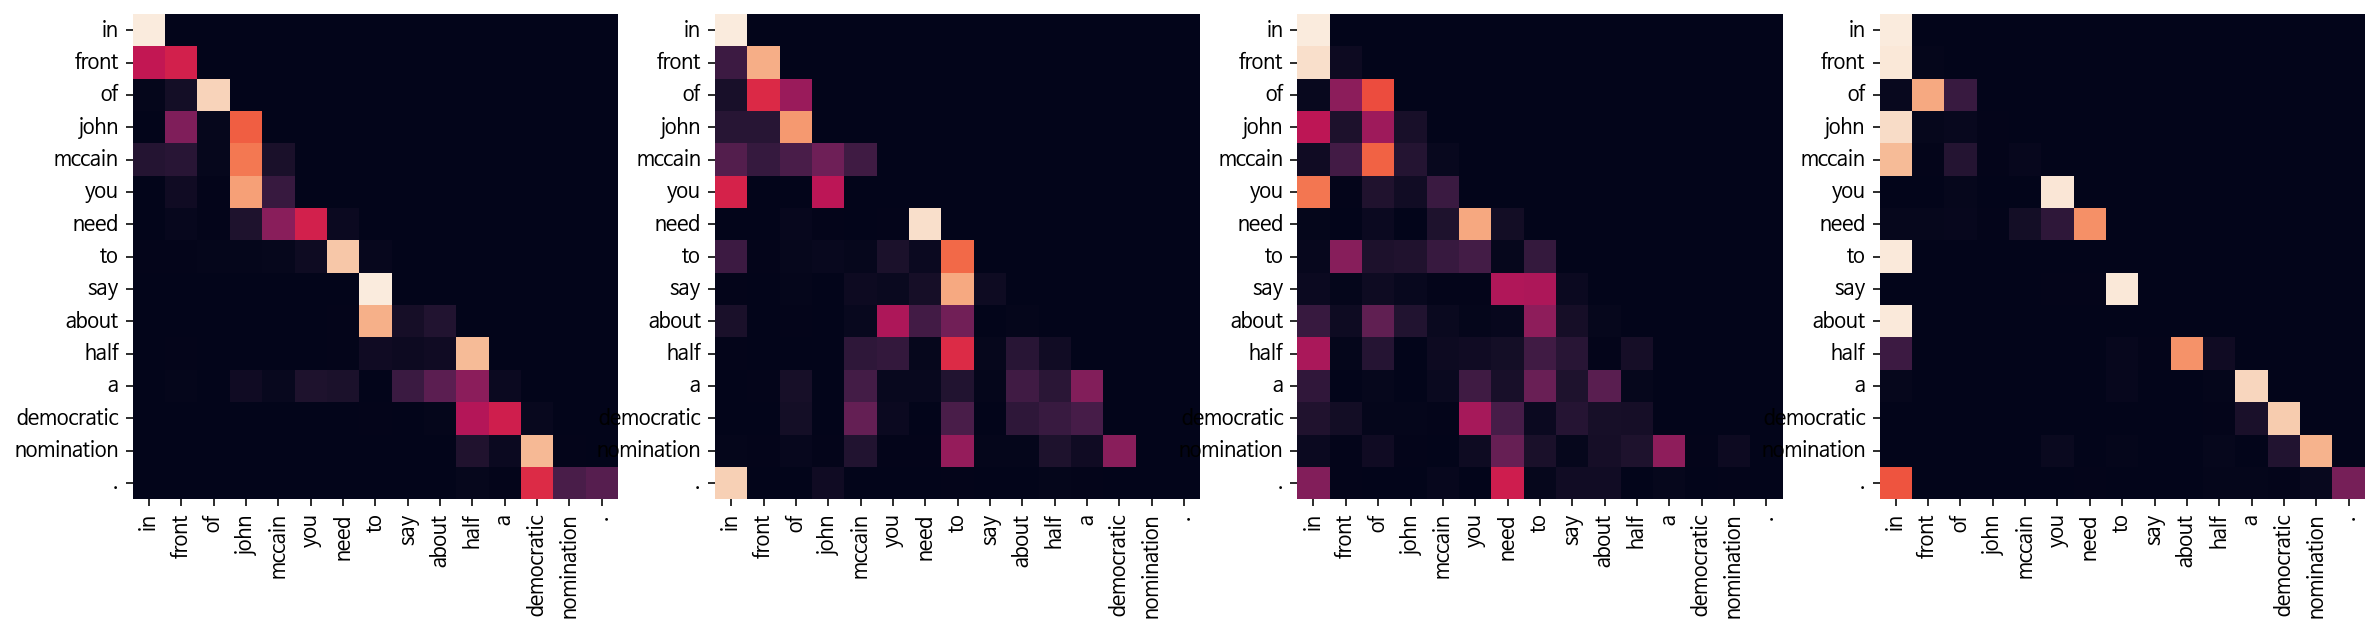

Decoder Src Layer 1


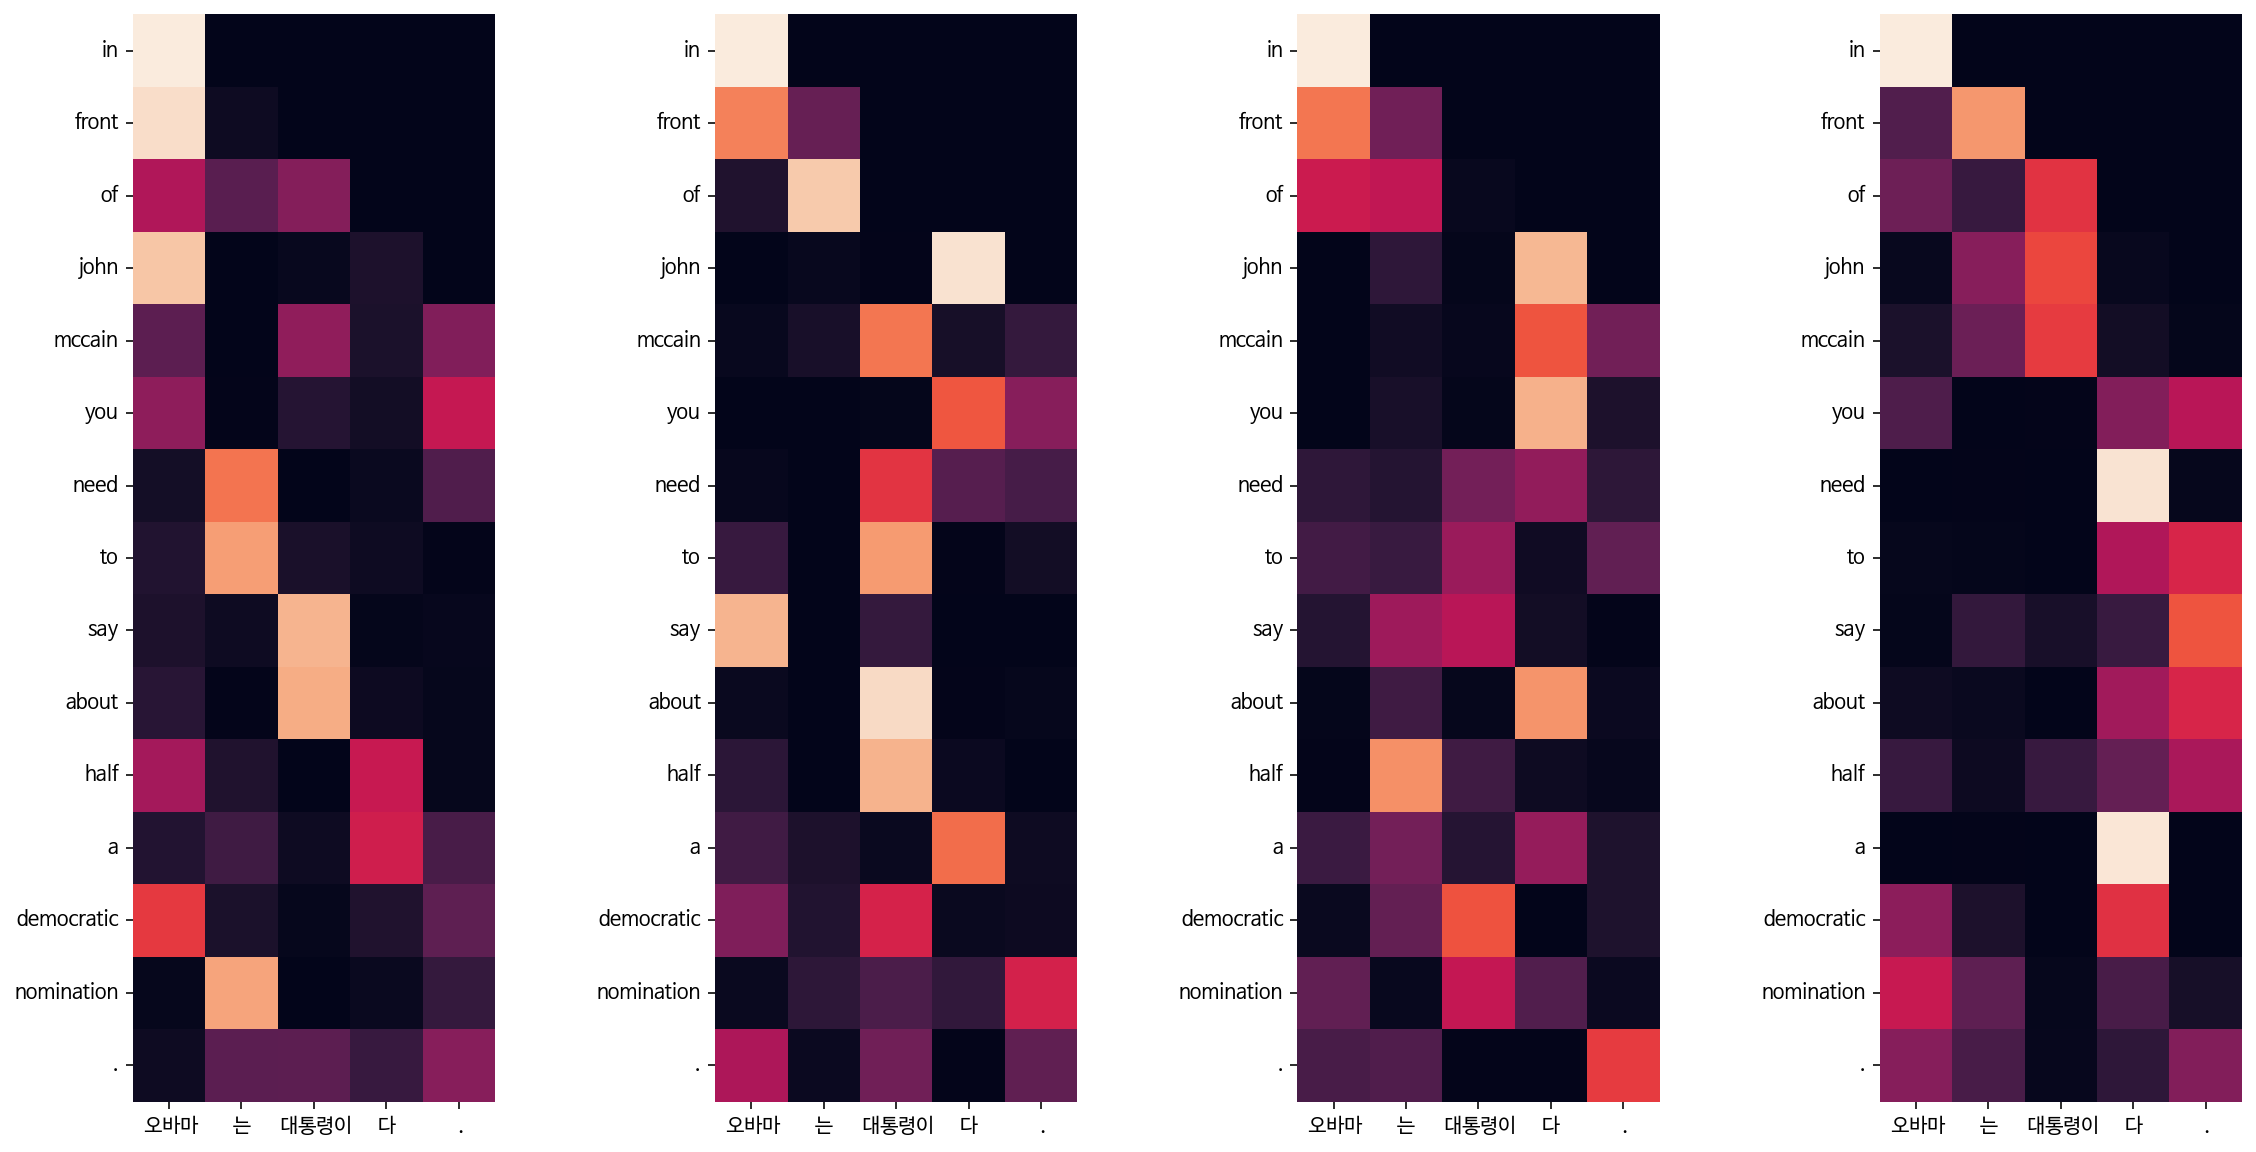

Decoder Self Layer 2


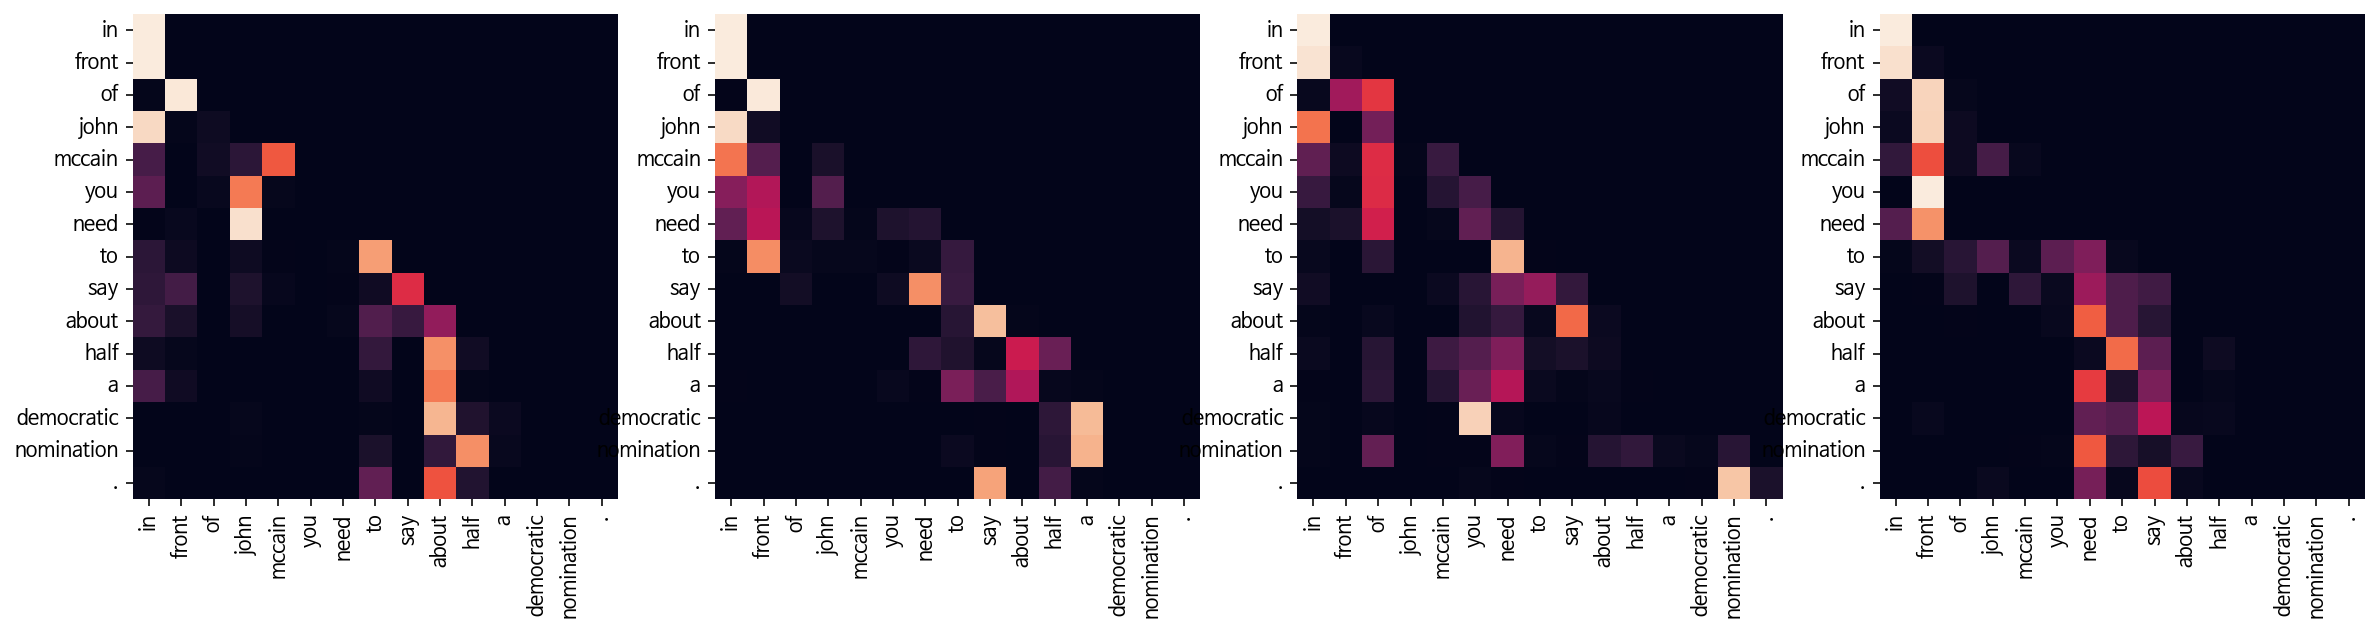

Decoder Src Layer 2


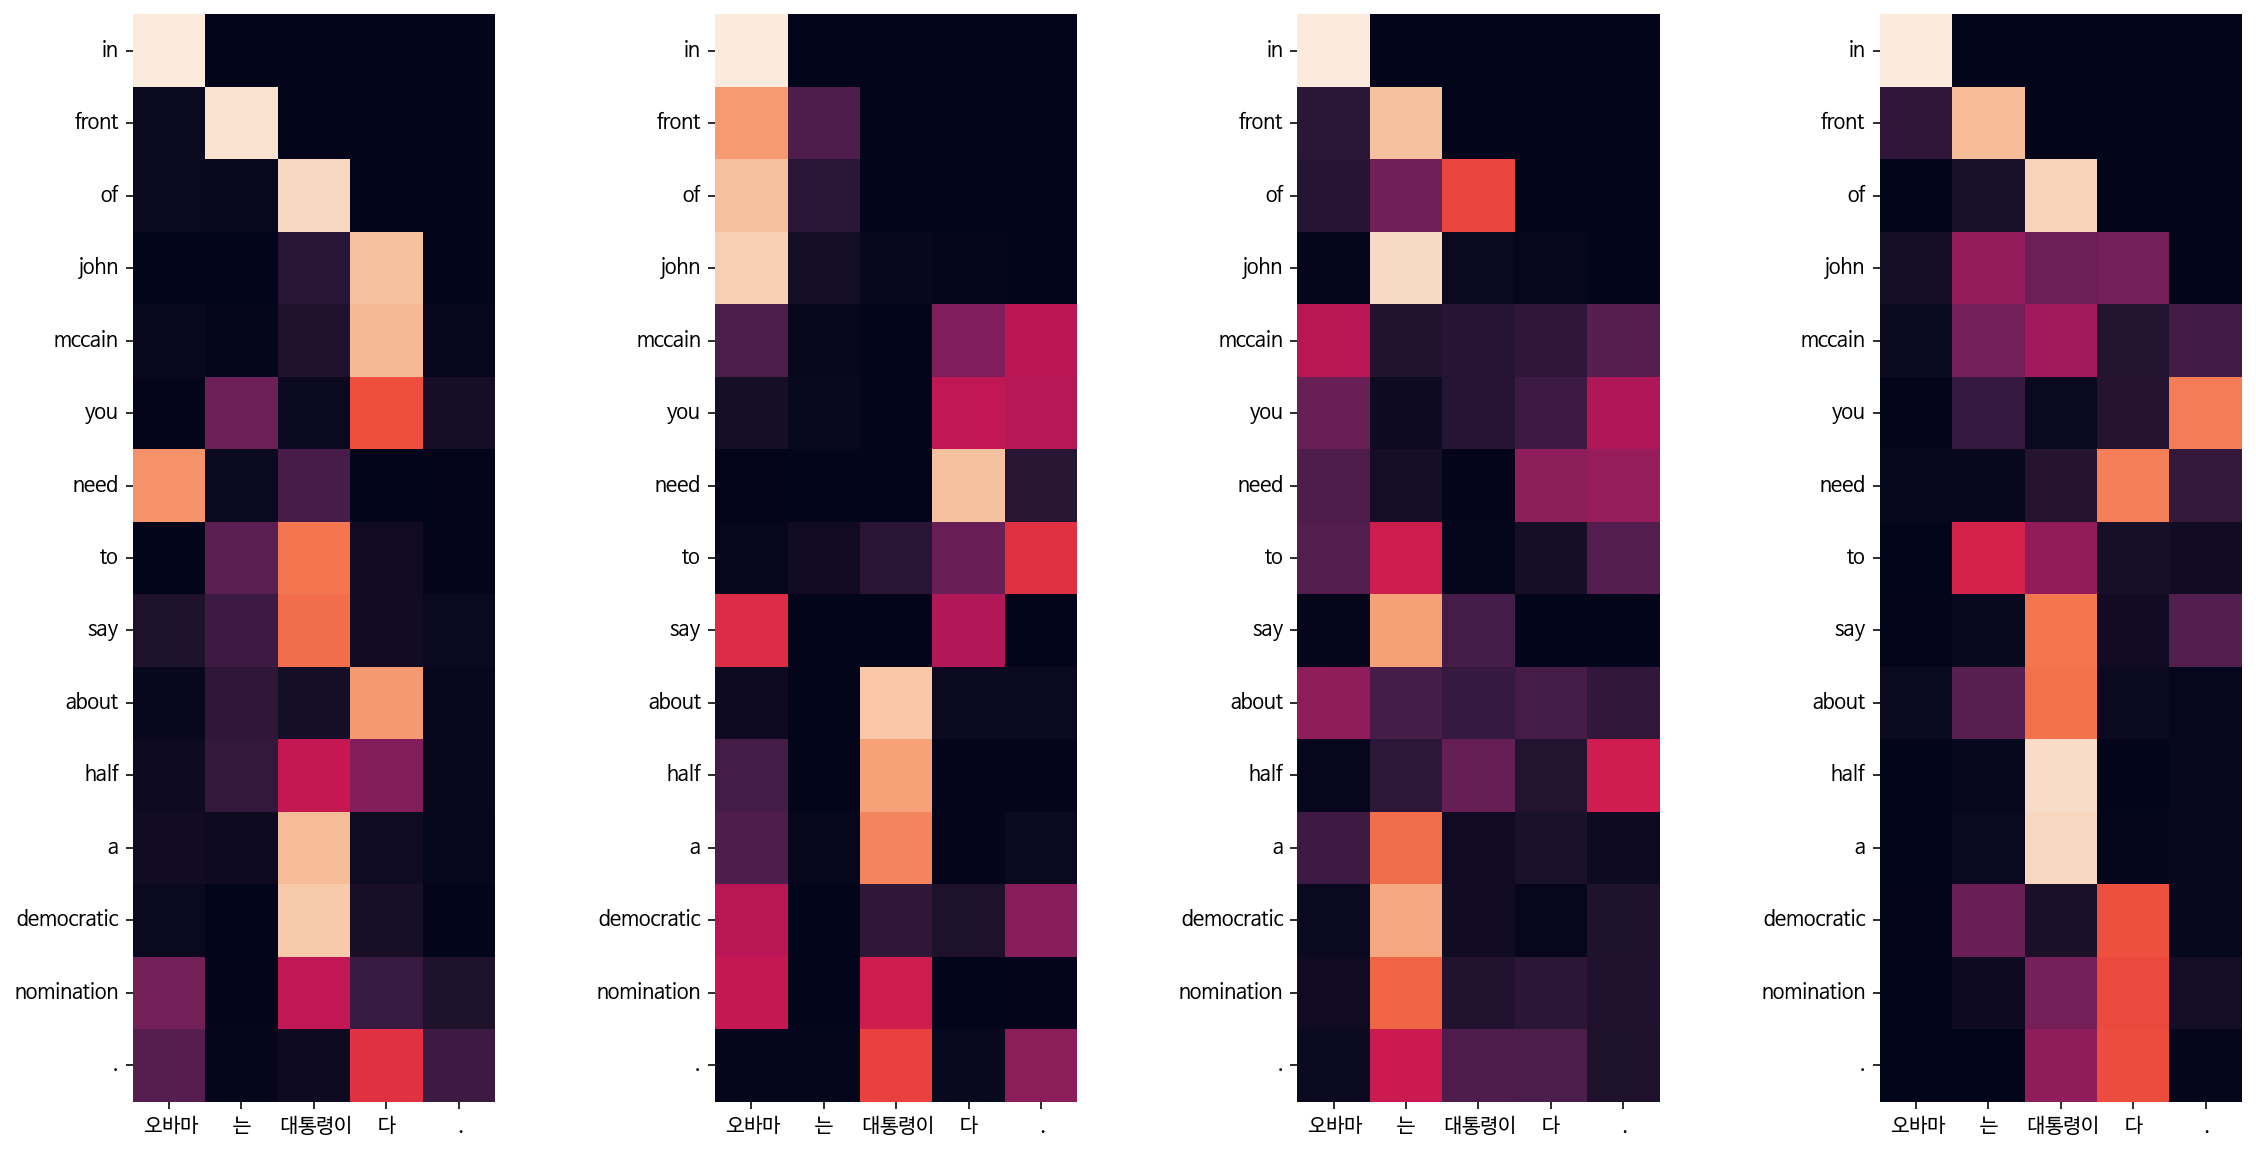

Input: 시민들은 도시 속에 산다.
Predicted translation: joe torres really let her go you all you start about
Encoder Layer 1


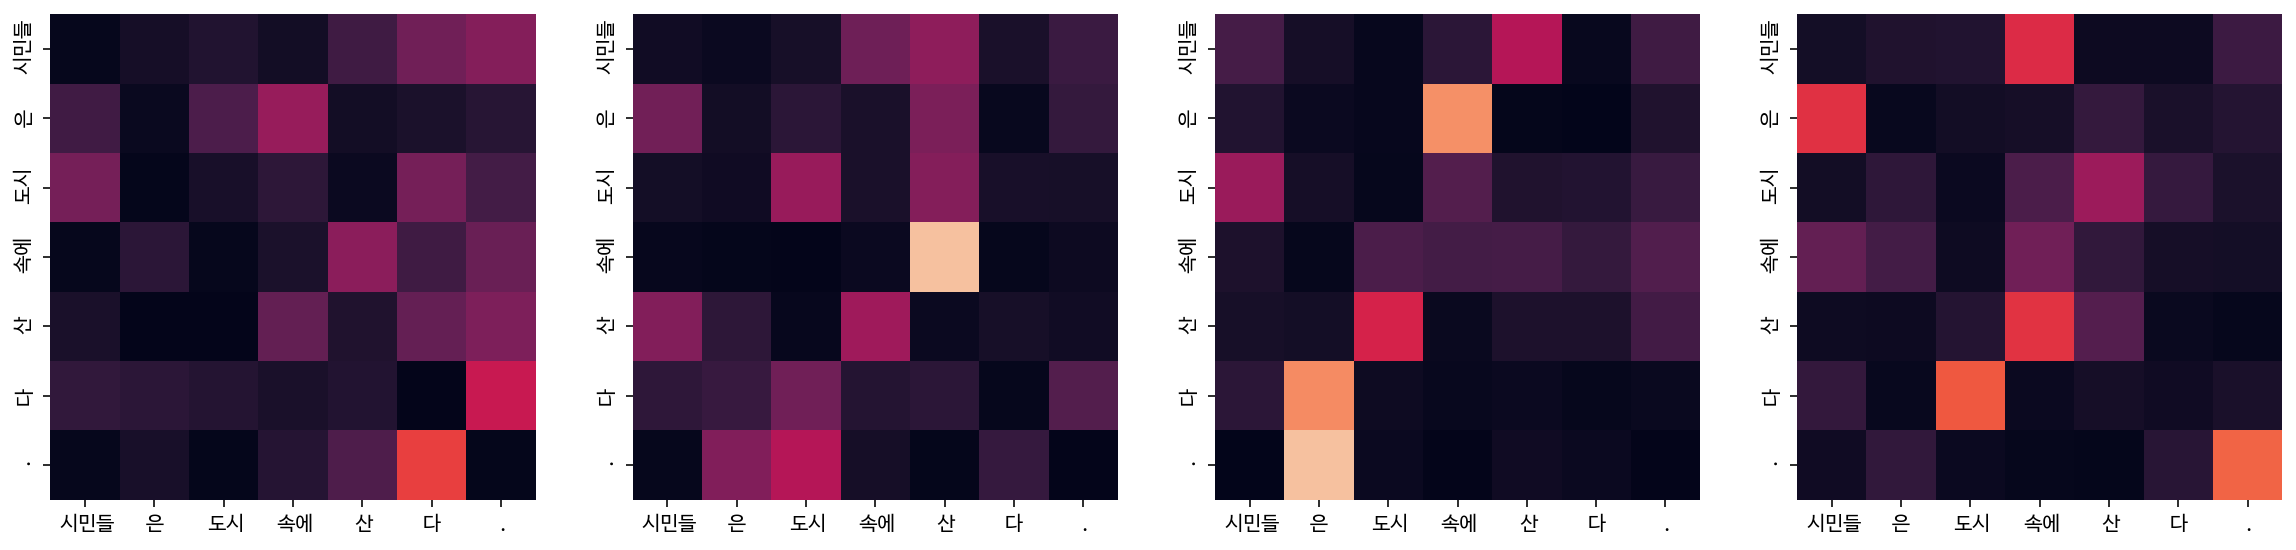

Encoder Layer 2


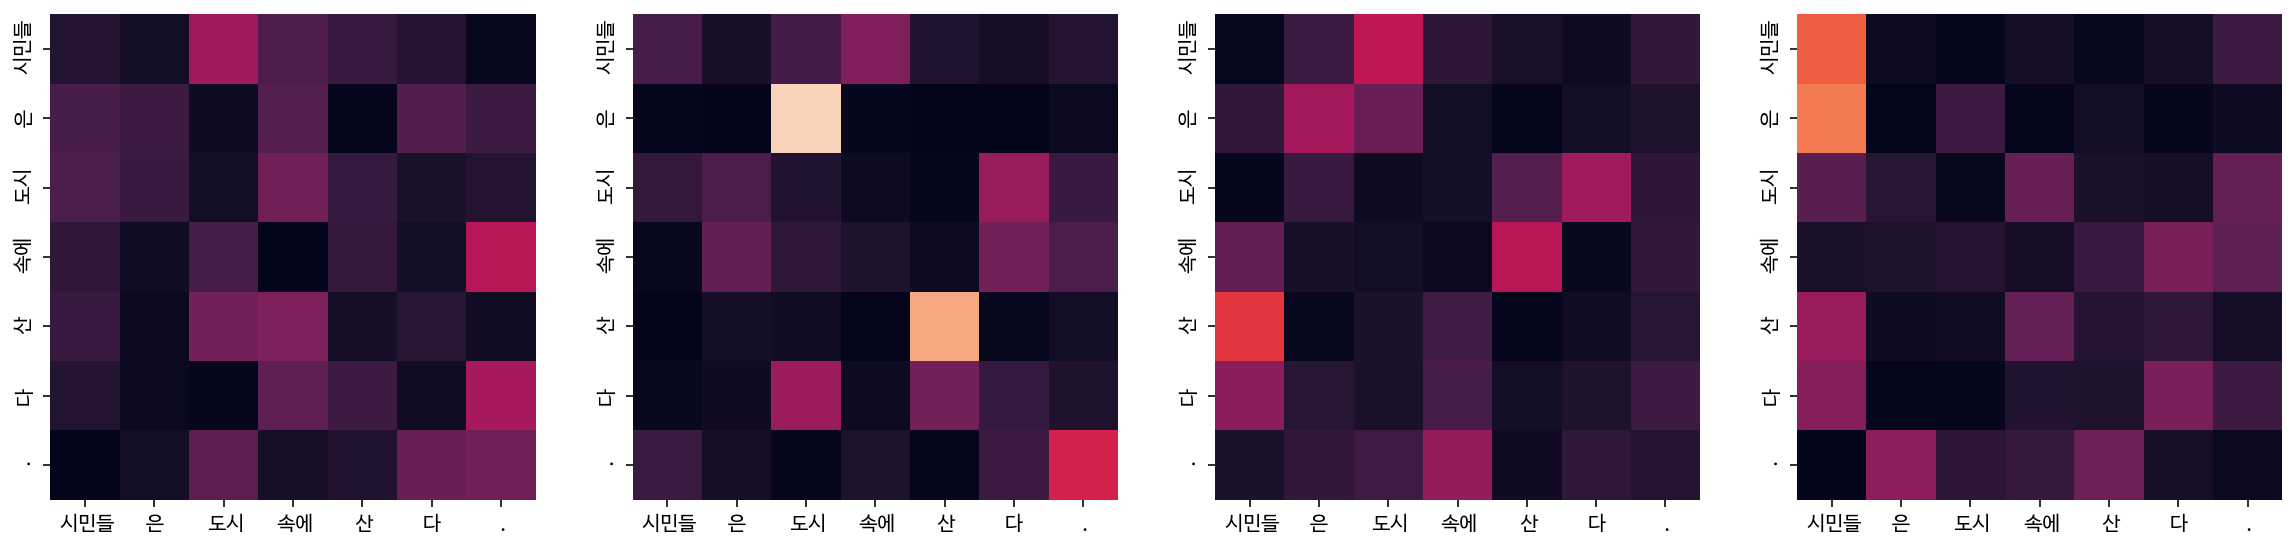

Decoder Self Layer 1


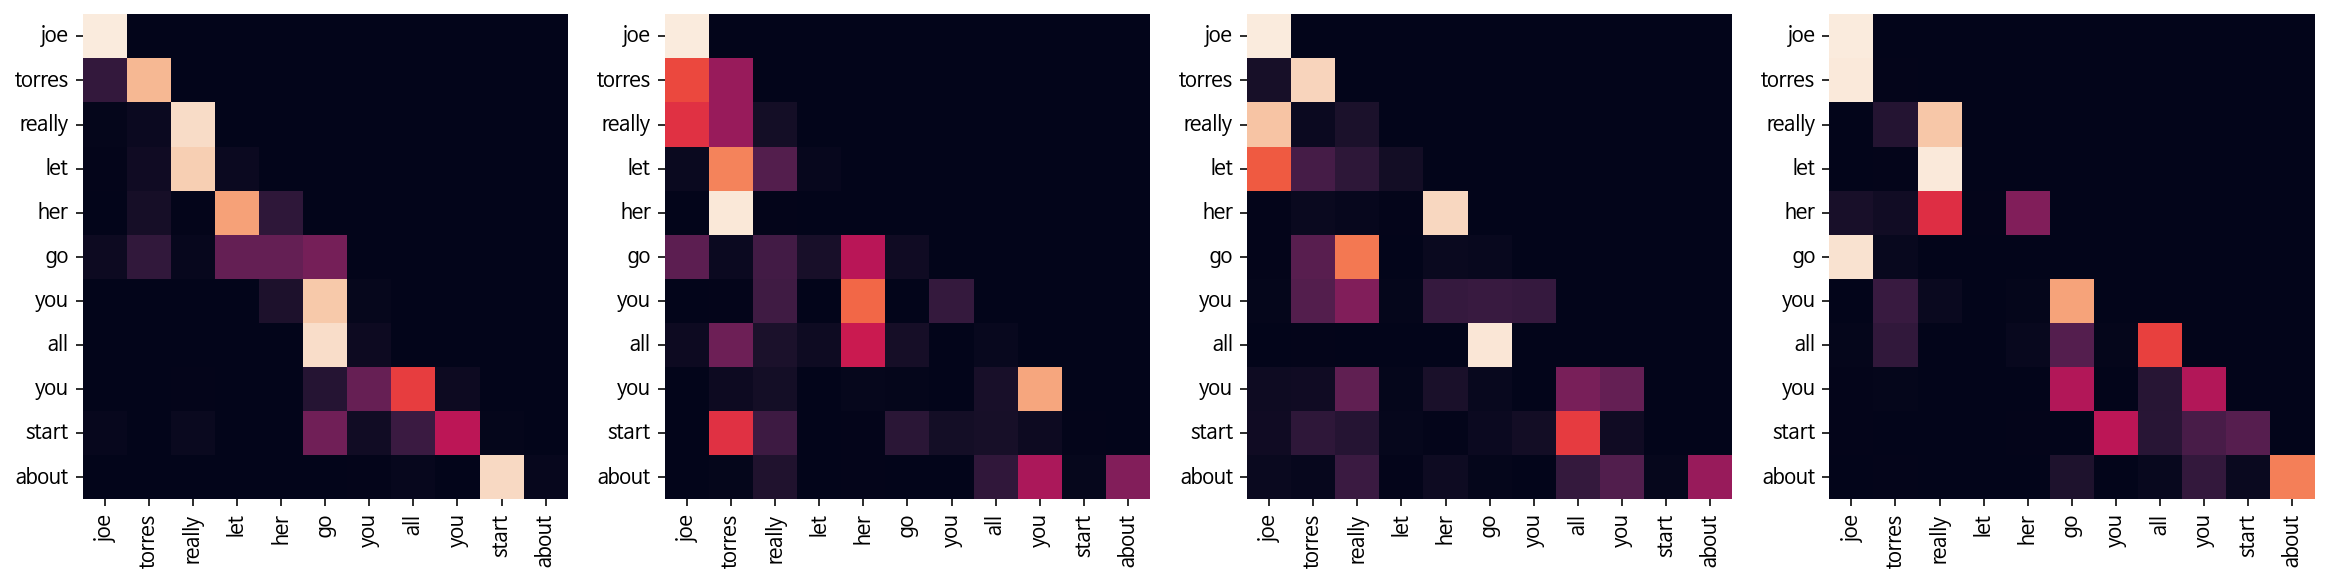

Decoder Src Layer 1


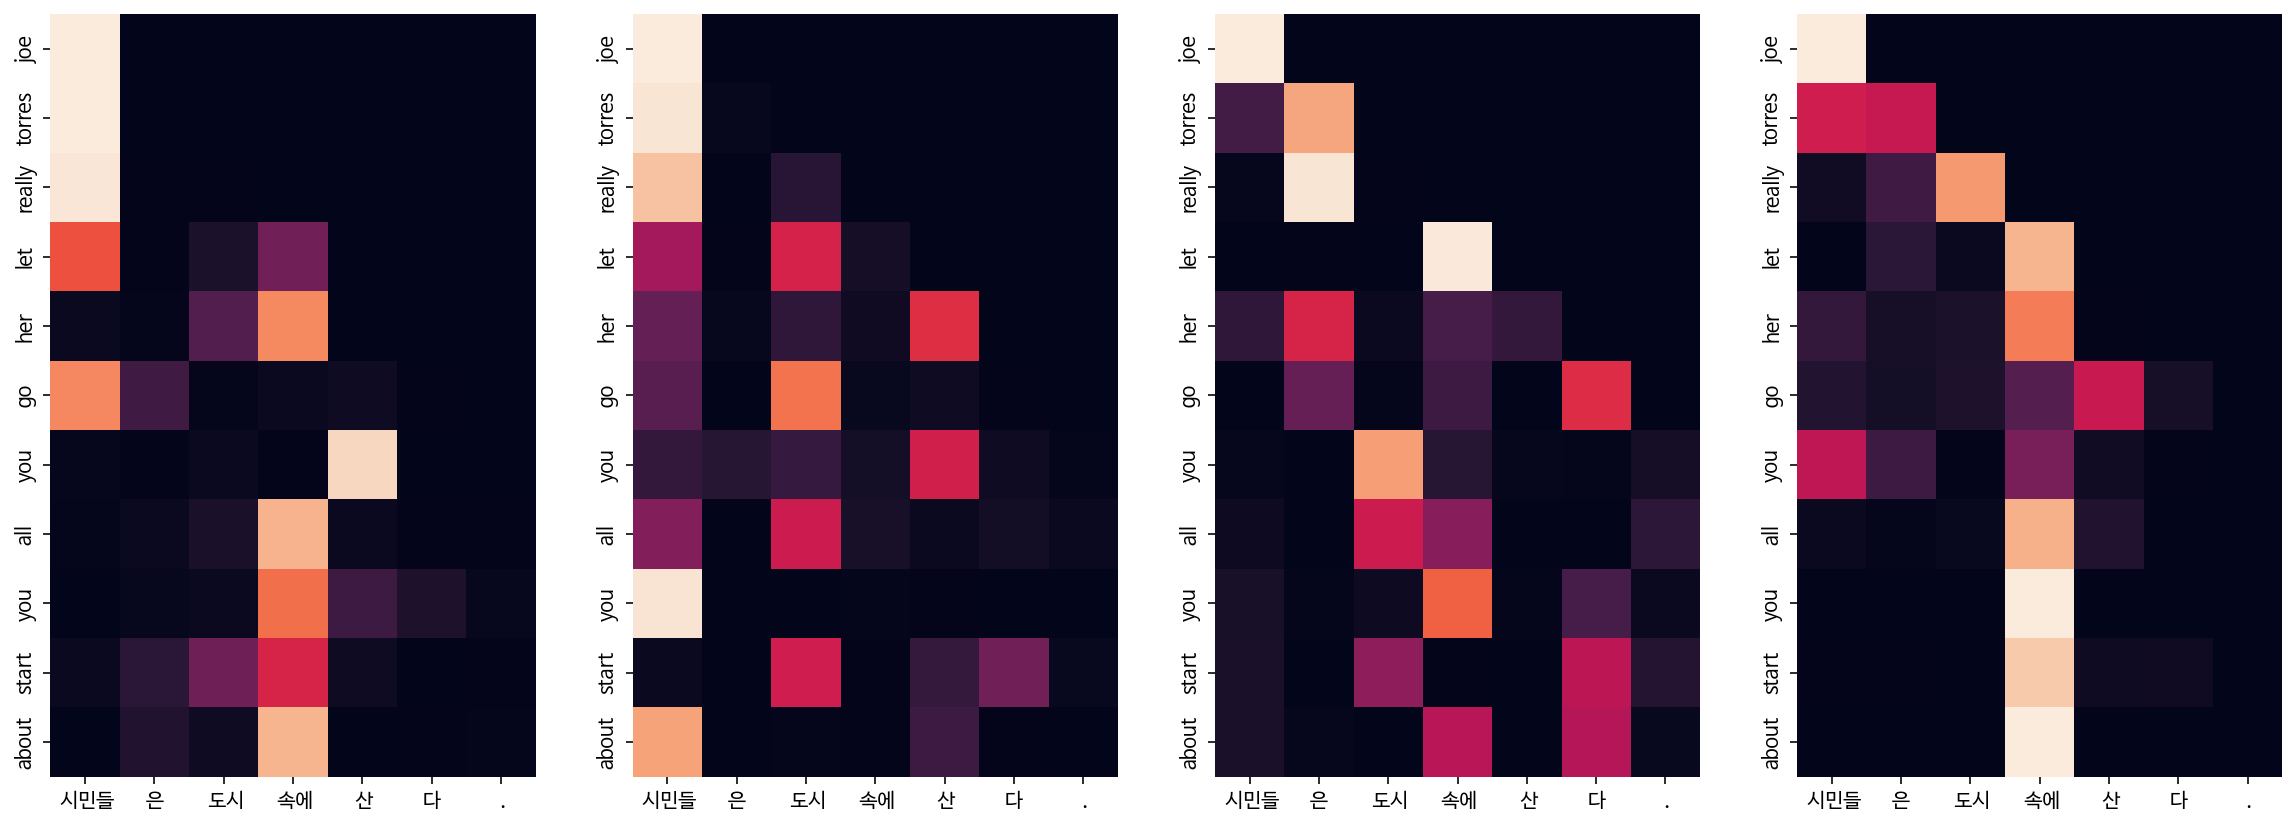

Decoder Self Layer 2


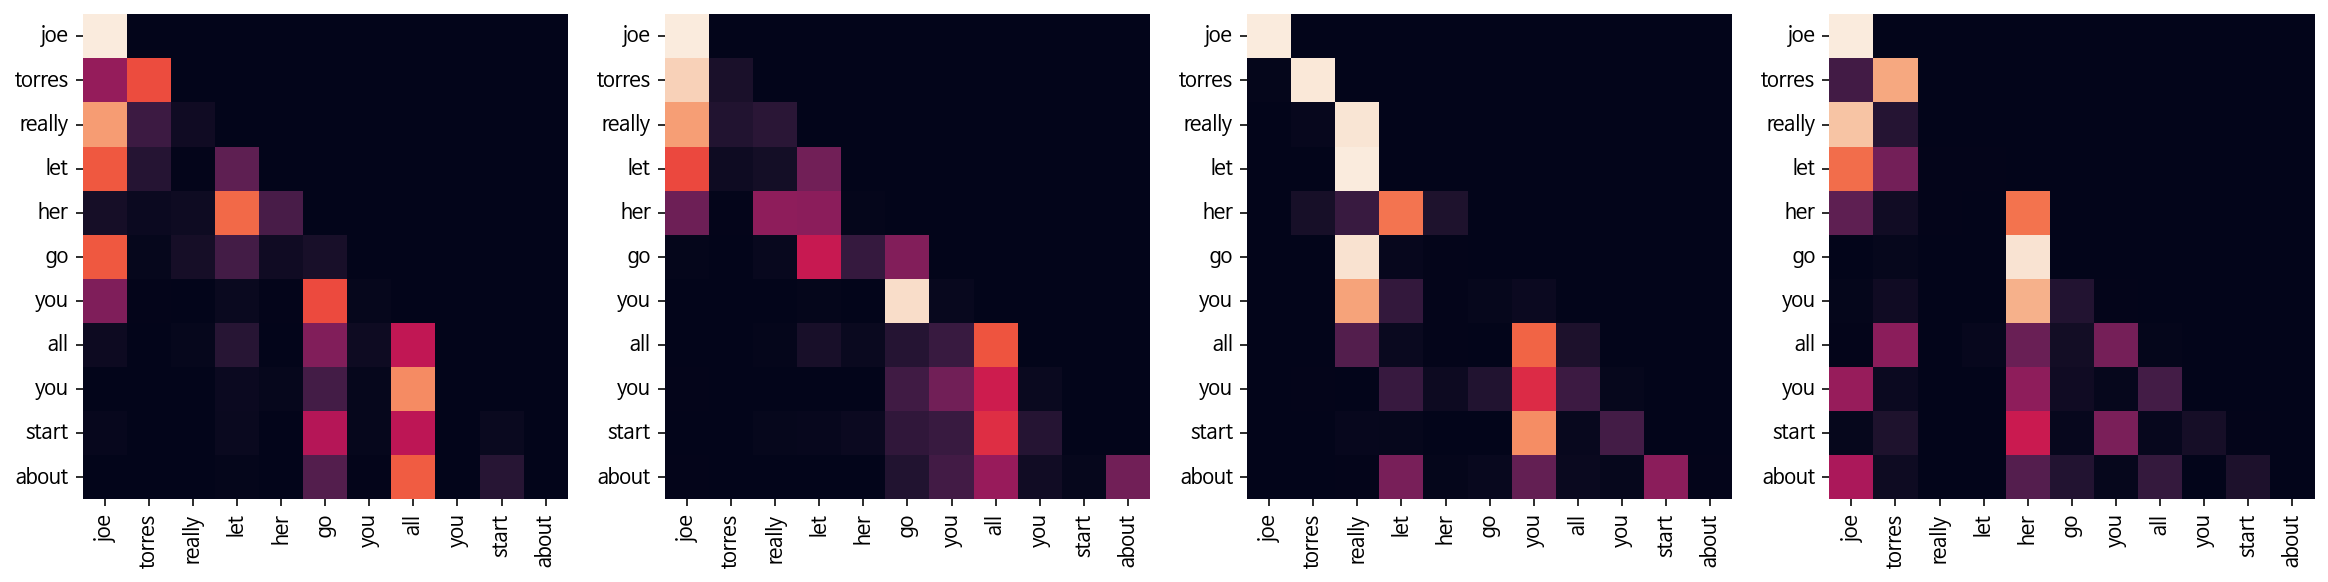

Decoder Src Layer 2


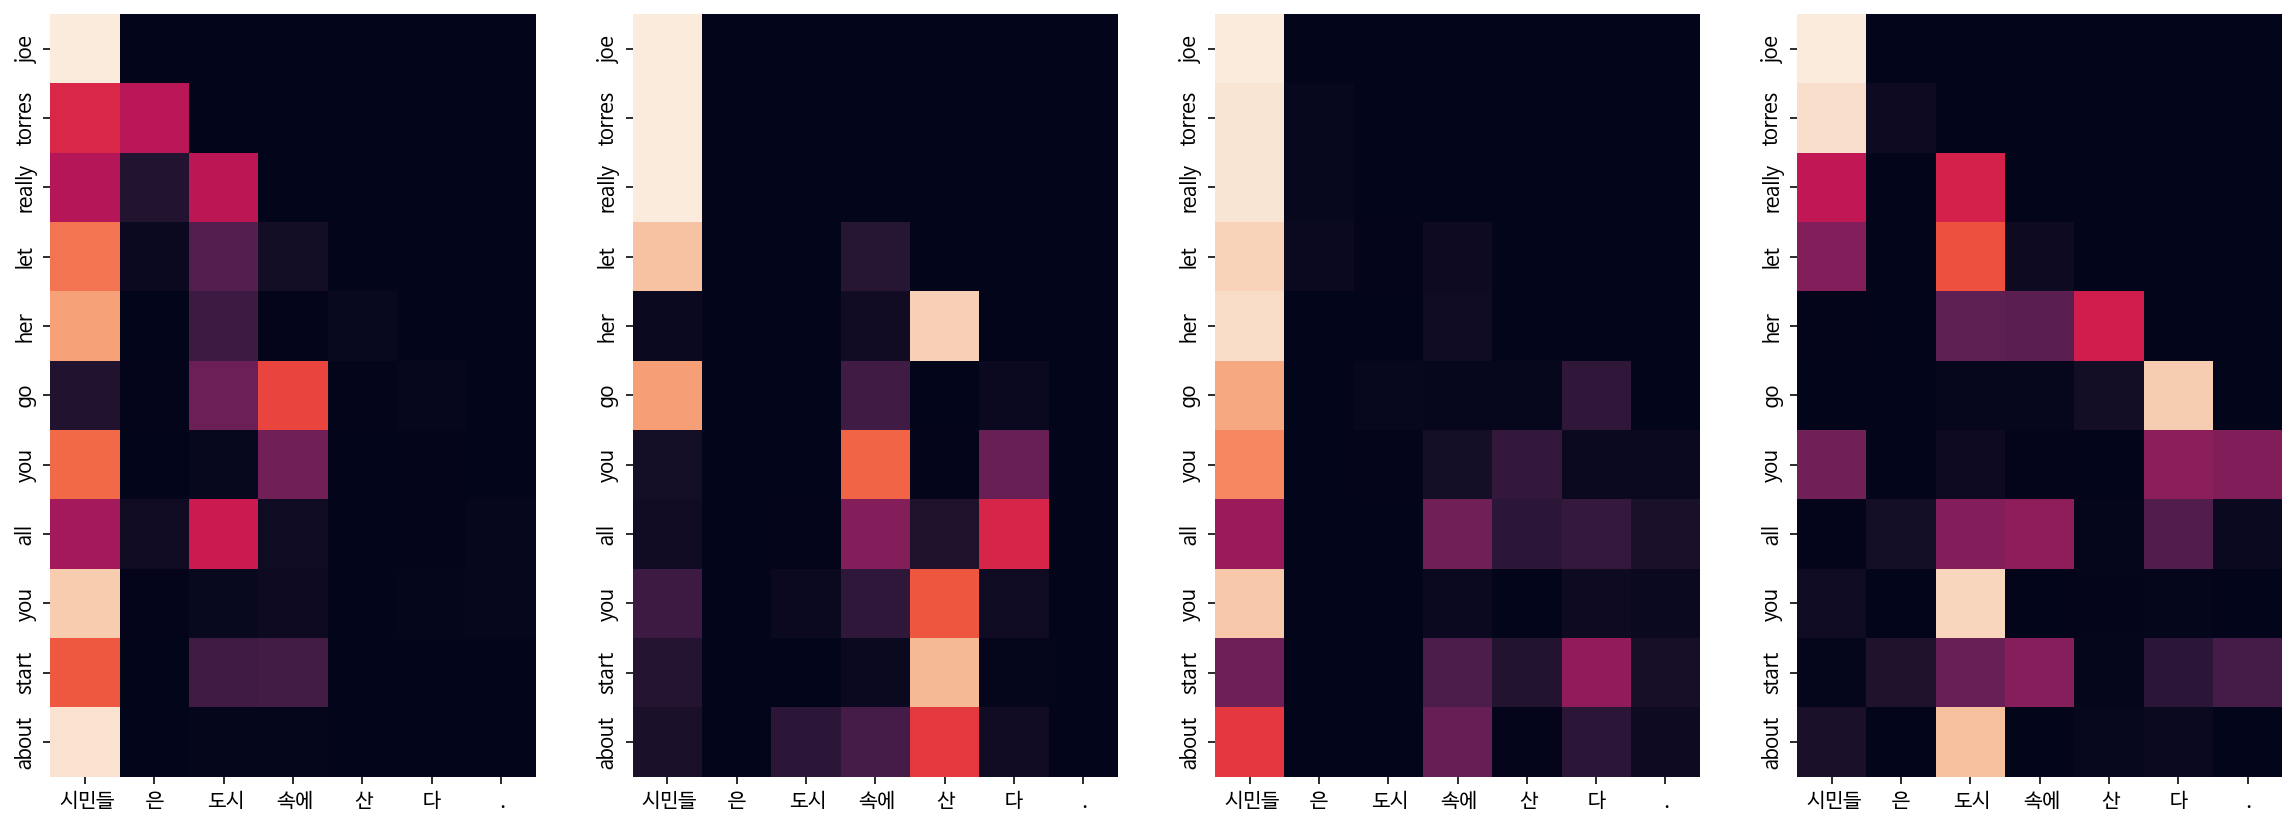

Input: 커피는 필요 없다.
Predicted translation: petraeus also said that different progress including the failed report included included iraqis in the work of included in before the uk , included international forces and the surrounding cities in baghdad .
Encoder Layer 1


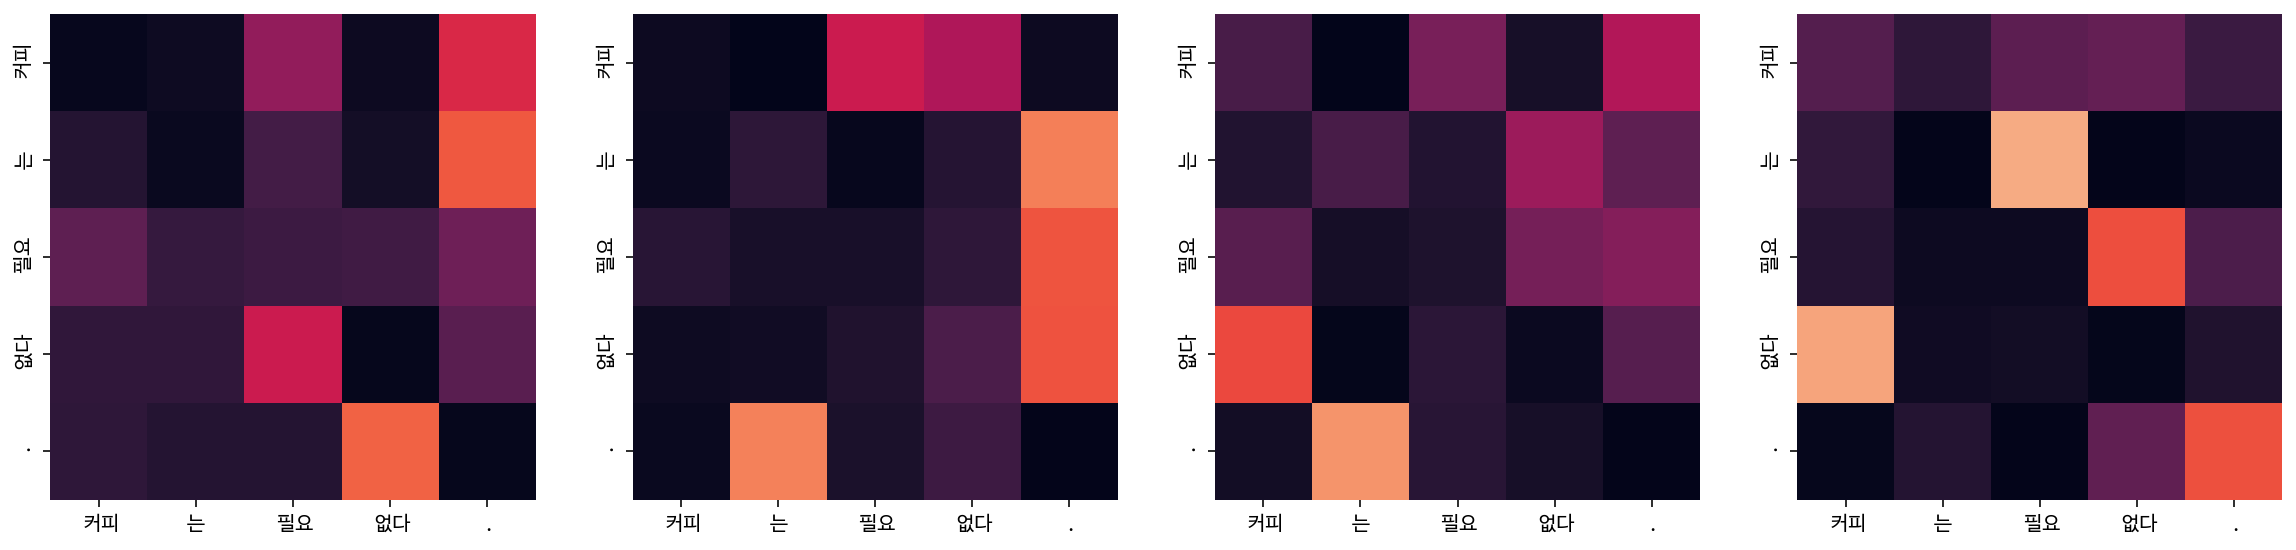

Encoder Layer 2


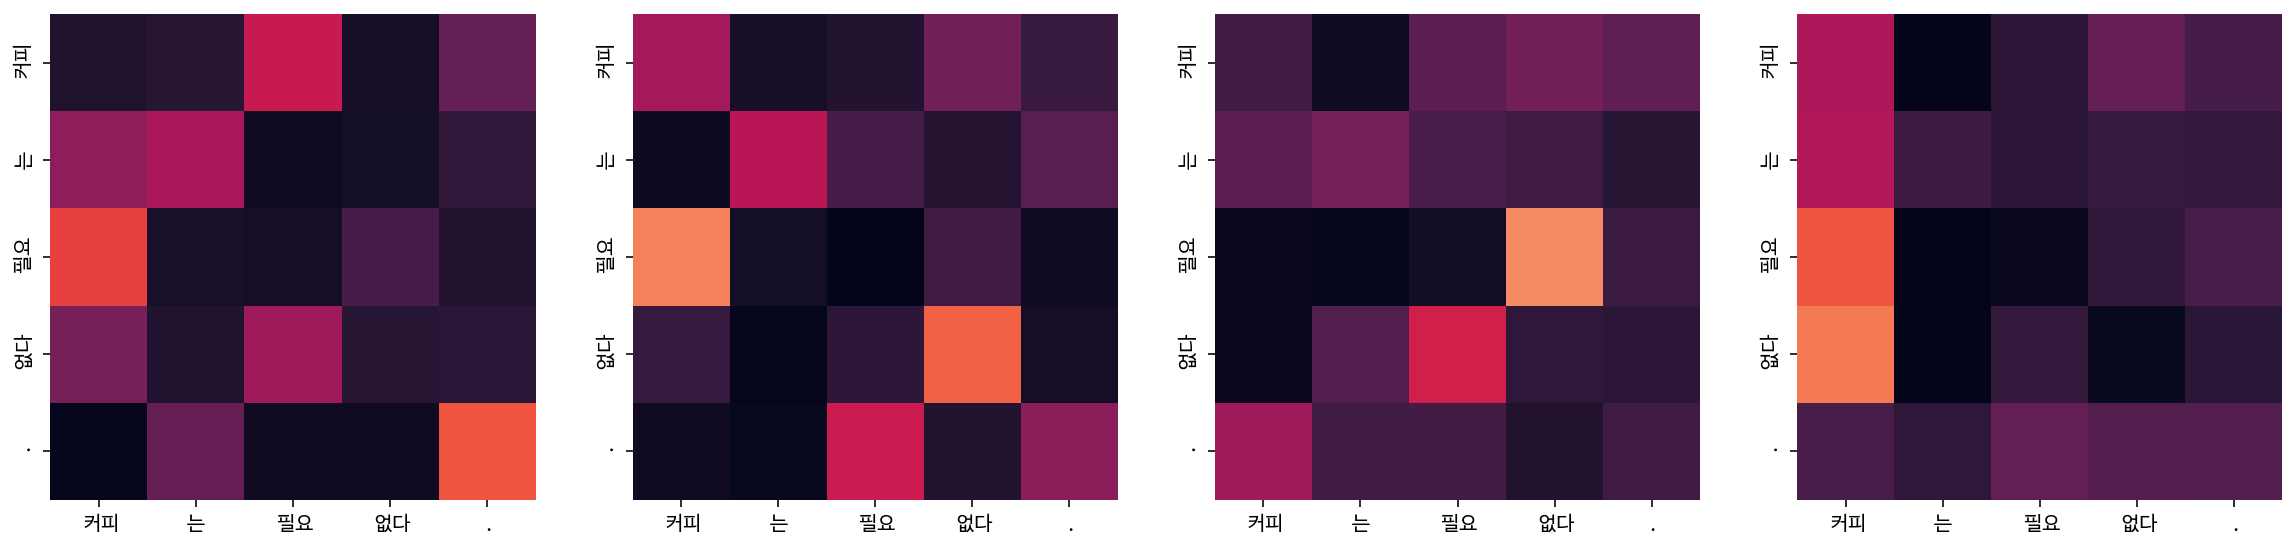

Decoder Self Layer 1


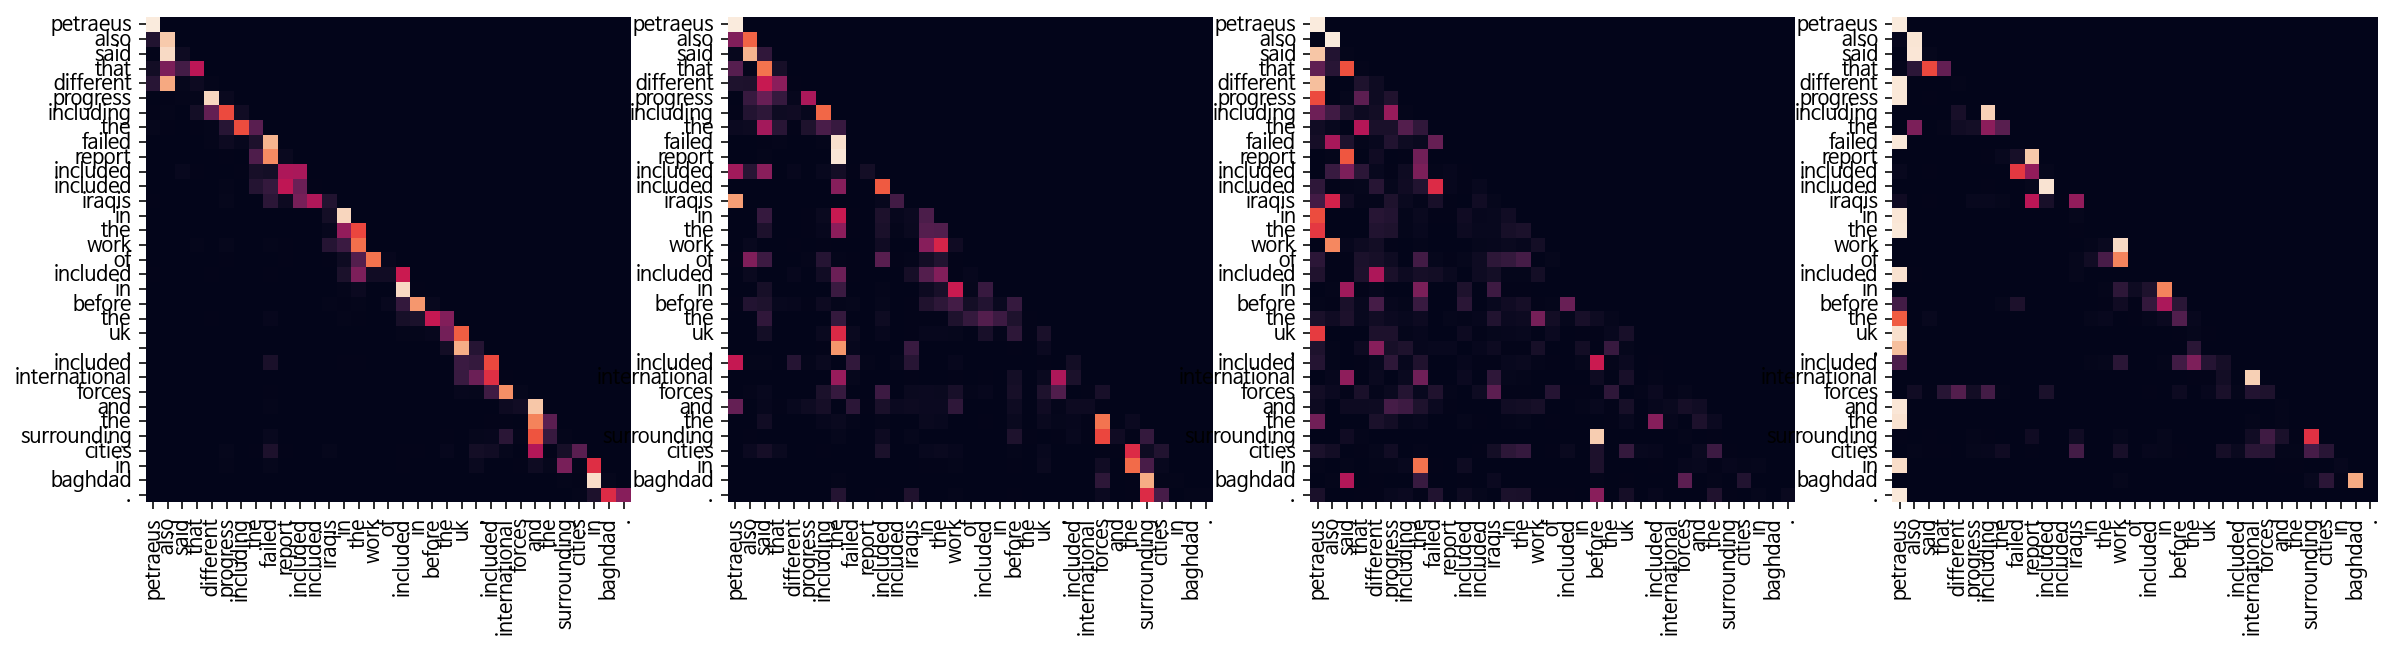

Decoder Src Layer 1


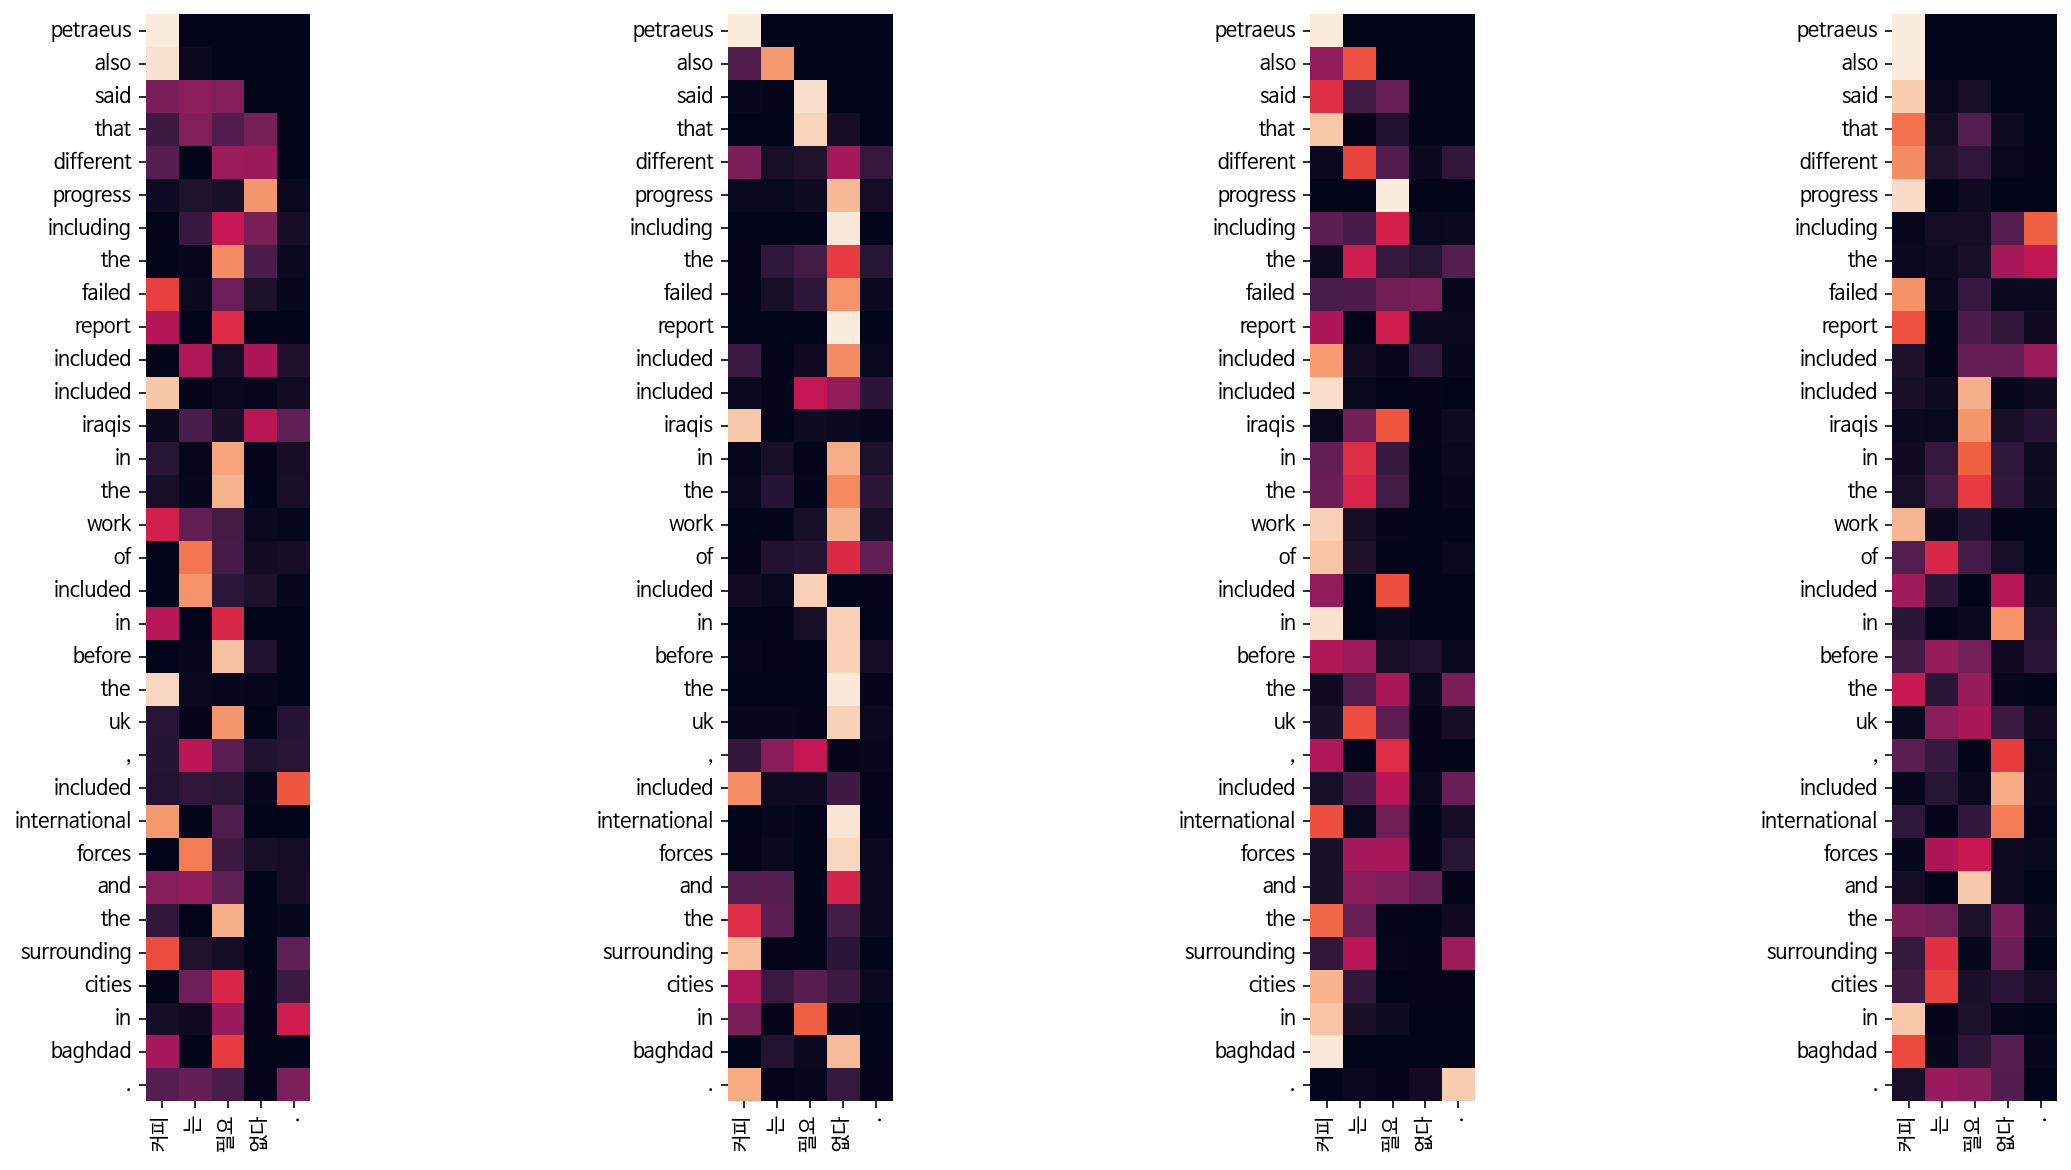

Decoder Self Layer 2


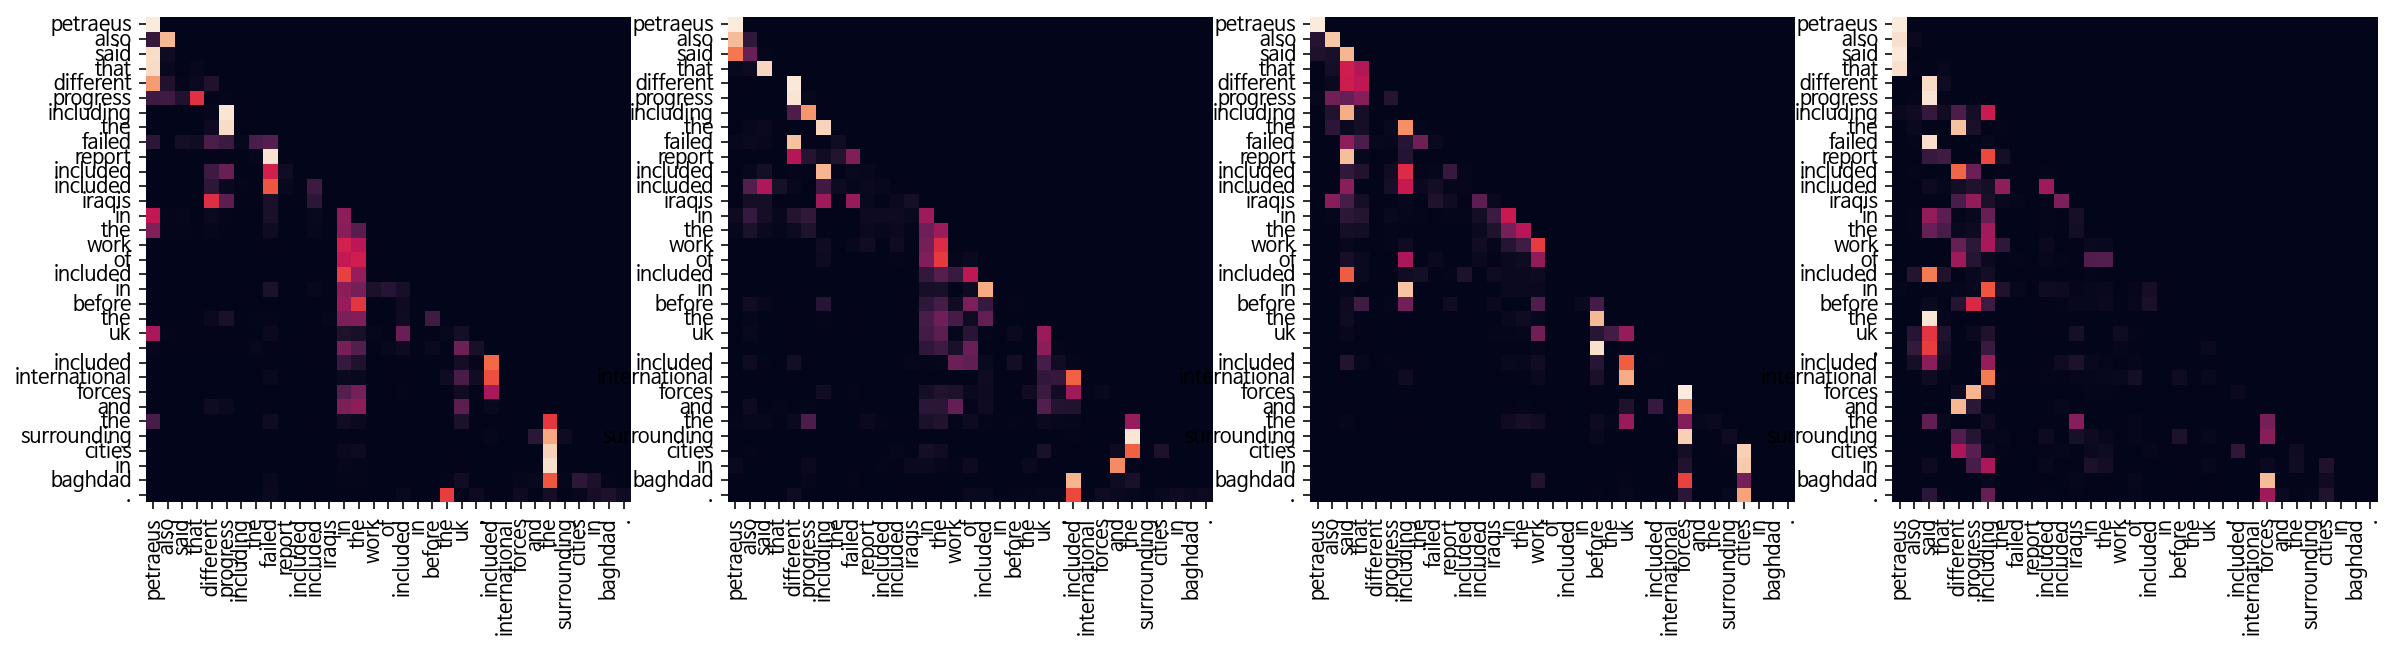

Decoder Src Layer 2


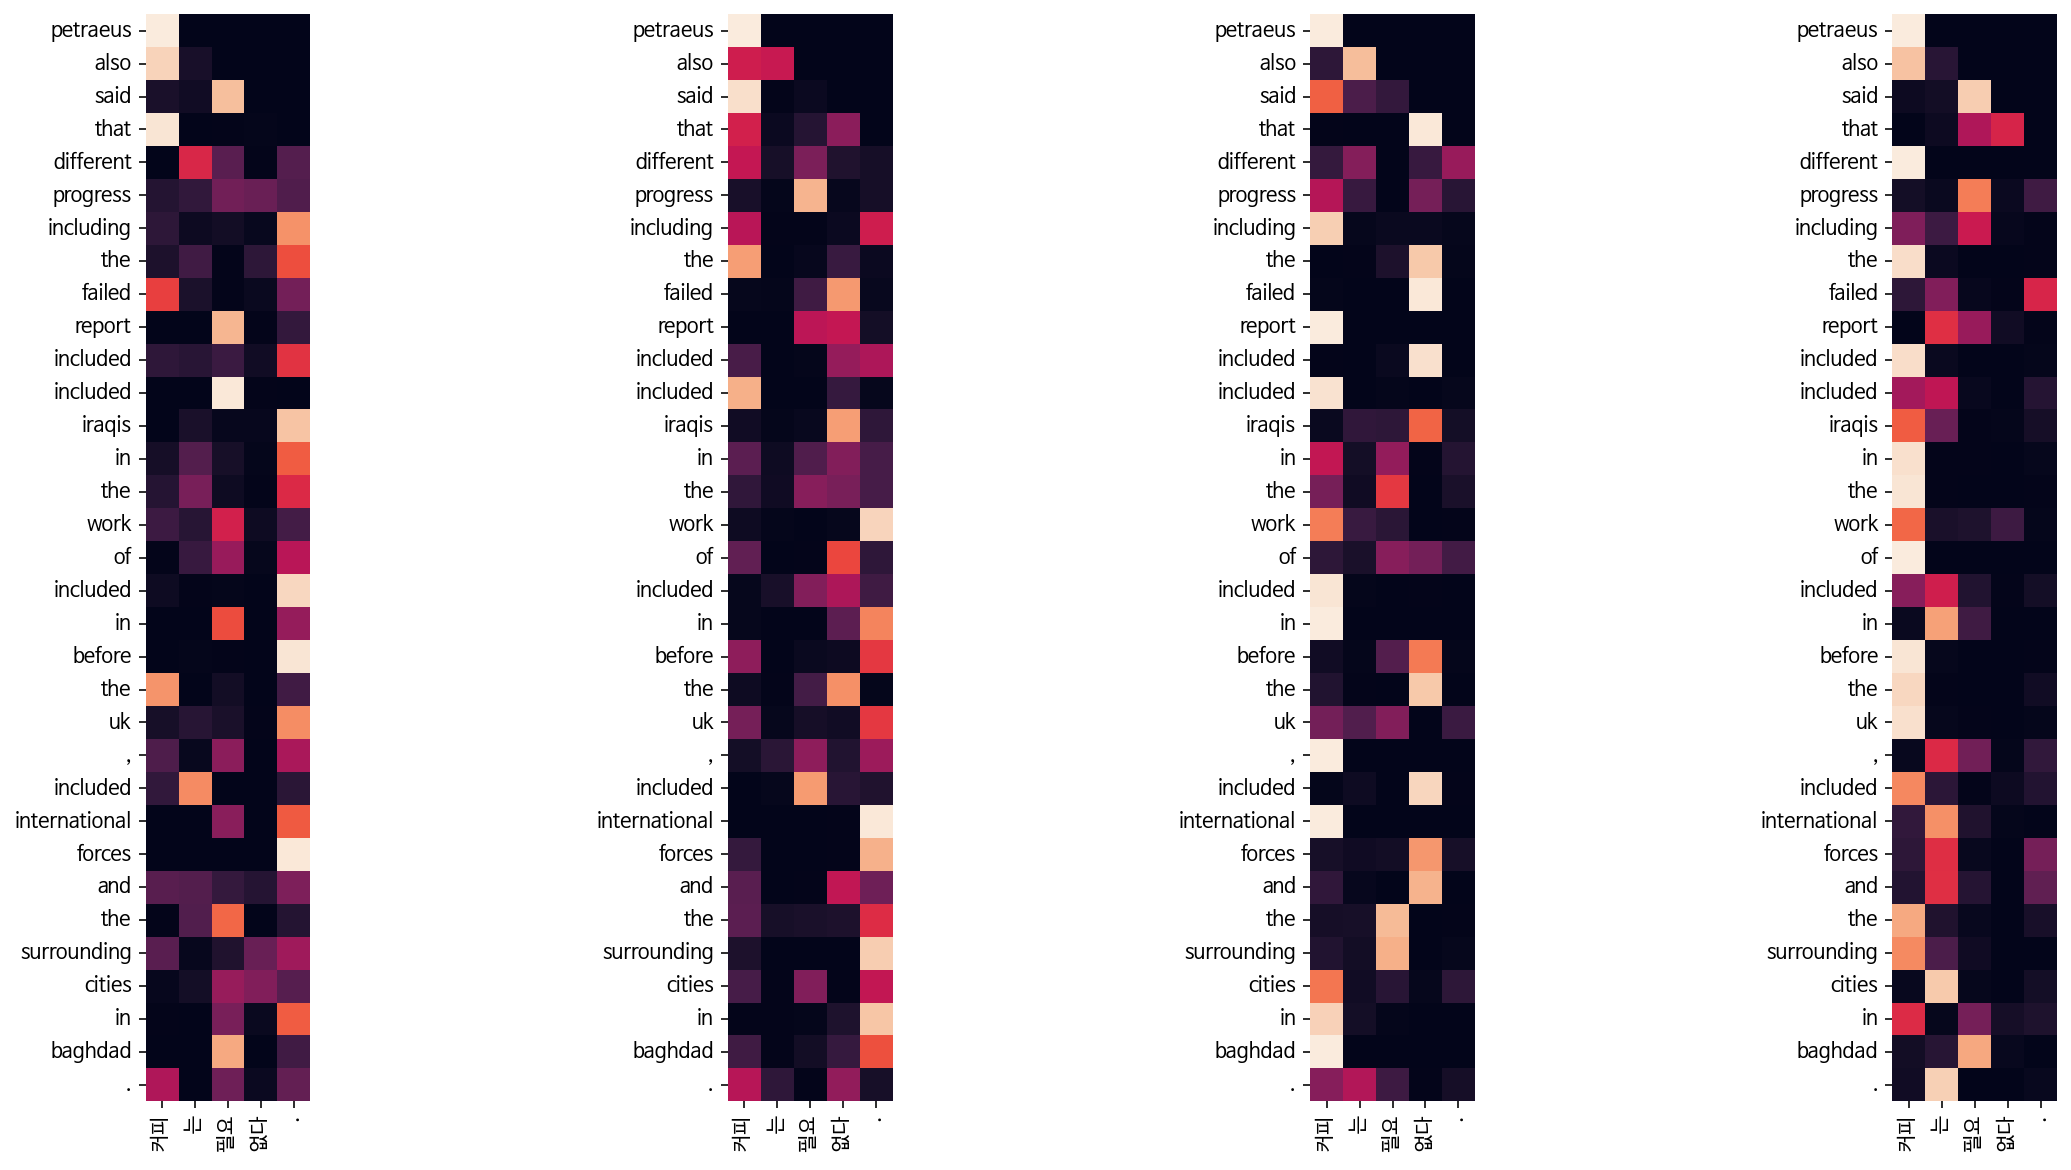

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: major giant pandas in the have been frequently of a cage , which is in the have been frequent acting in recent months .
Encoder Layer 1


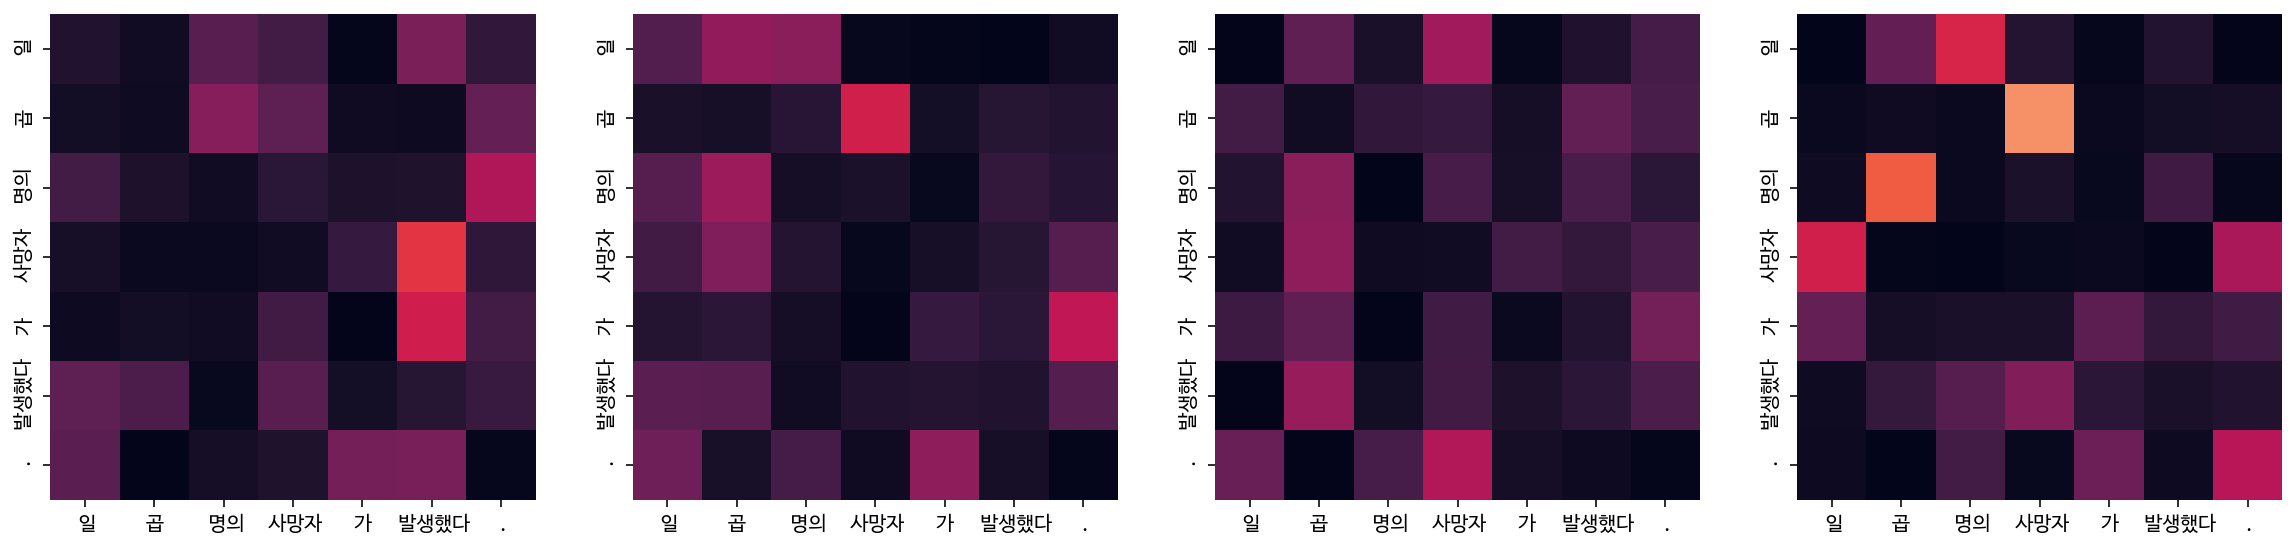

Encoder Layer 2


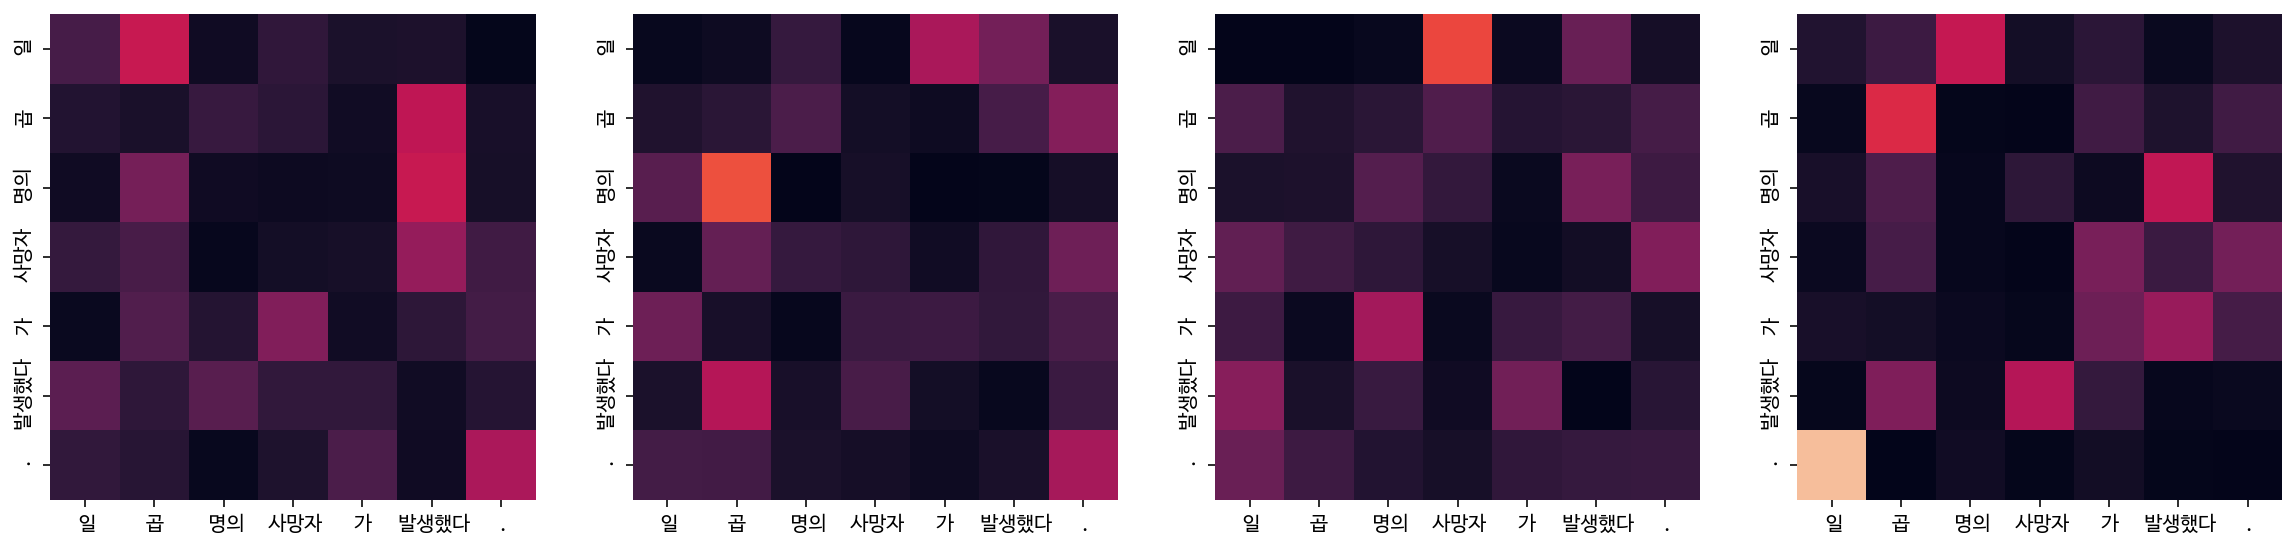

Decoder Self Layer 1


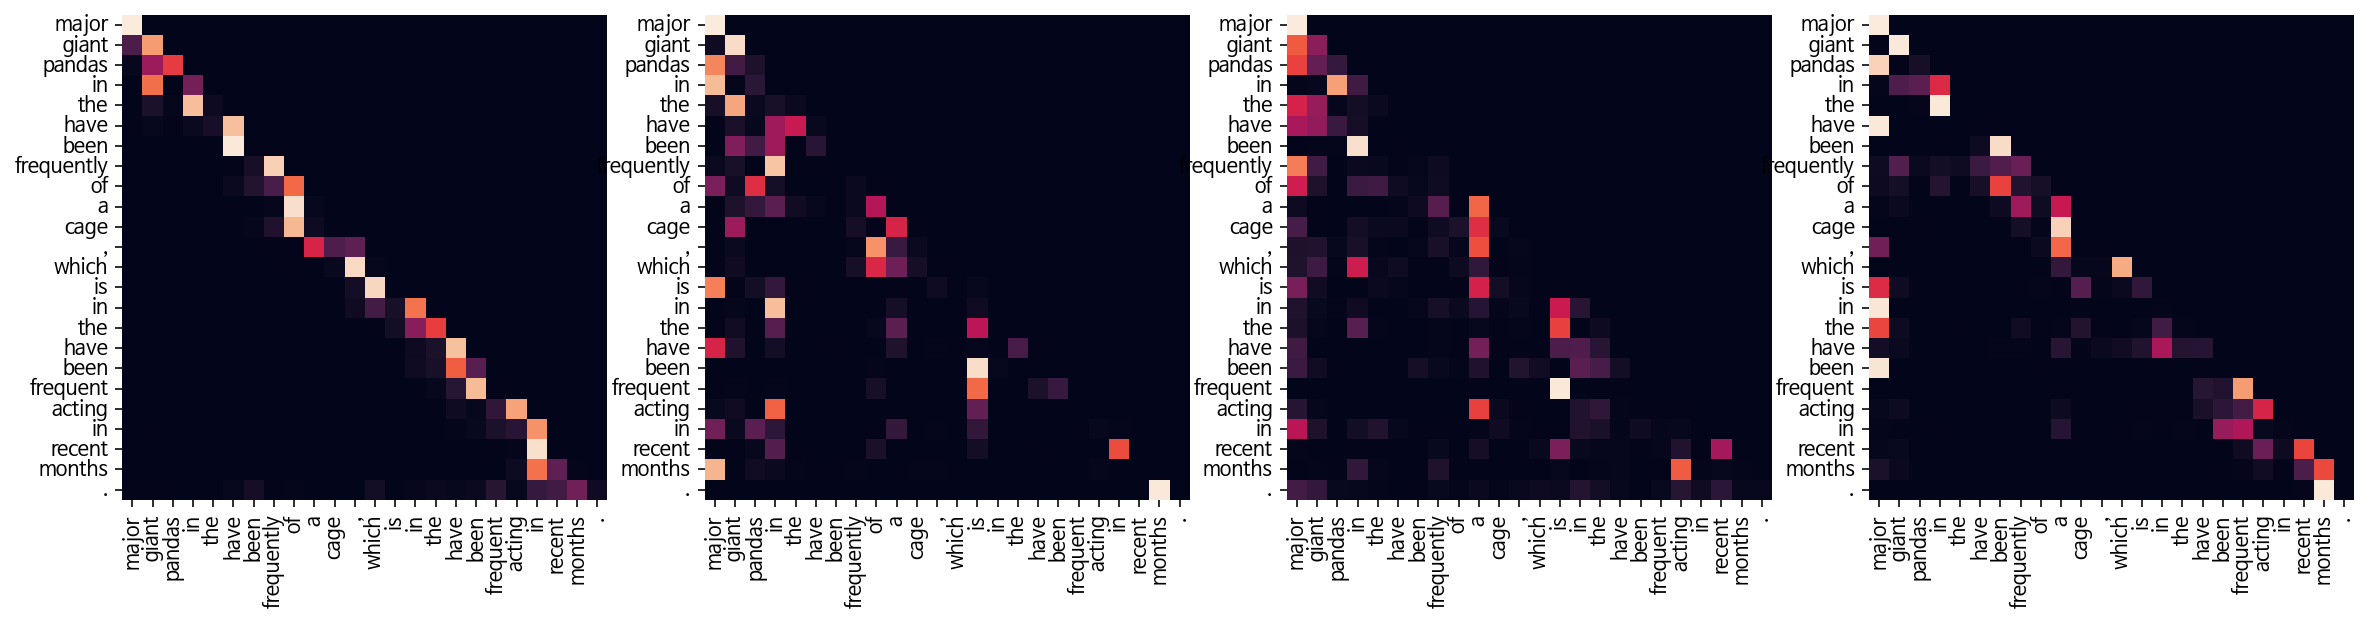

Decoder Src Layer 1


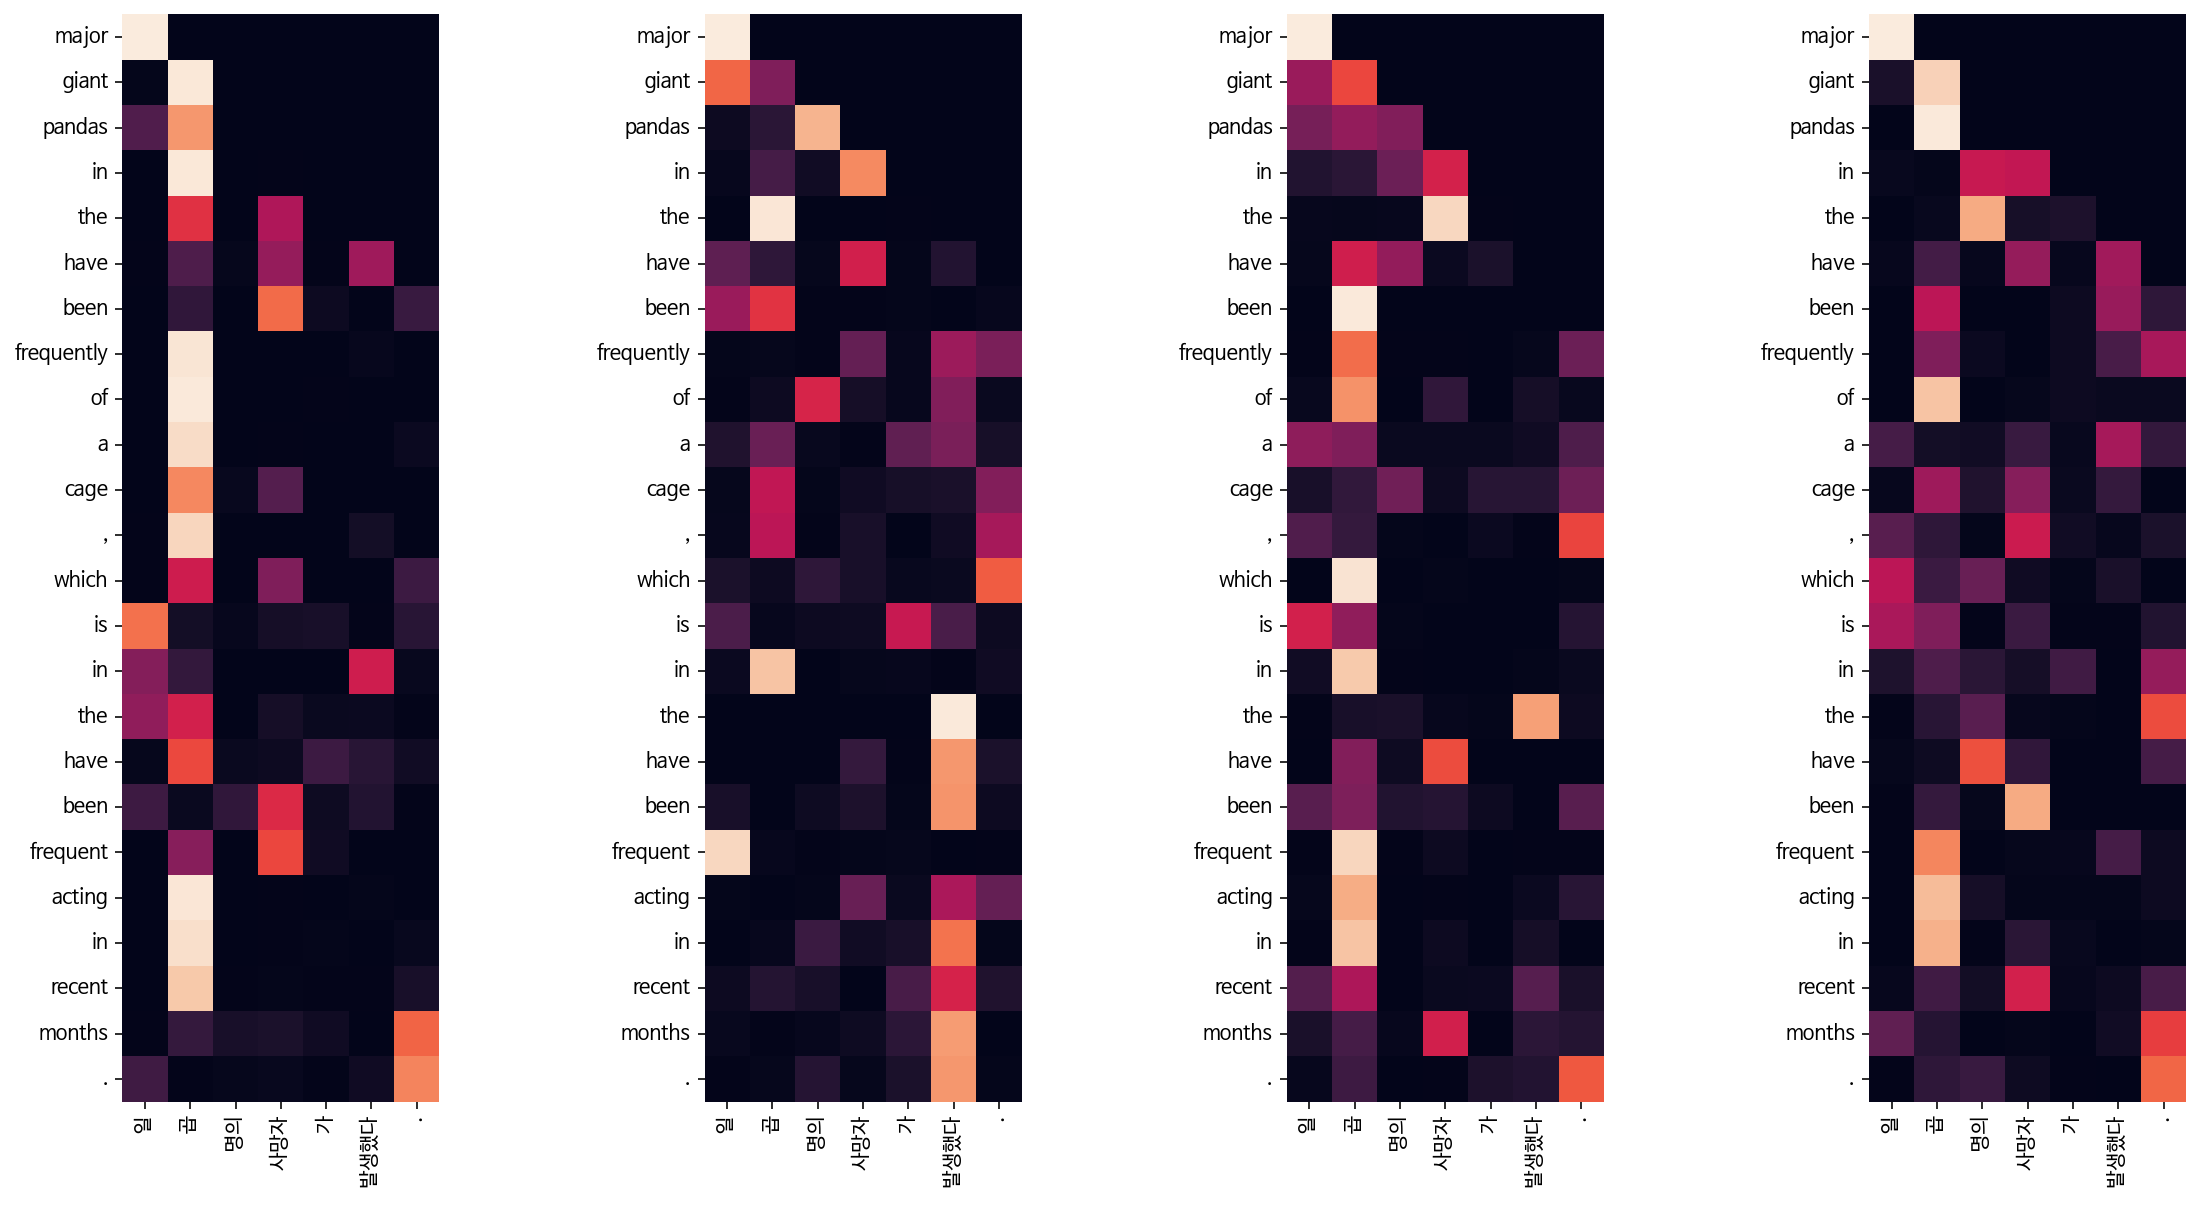

Decoder Self Layer 2


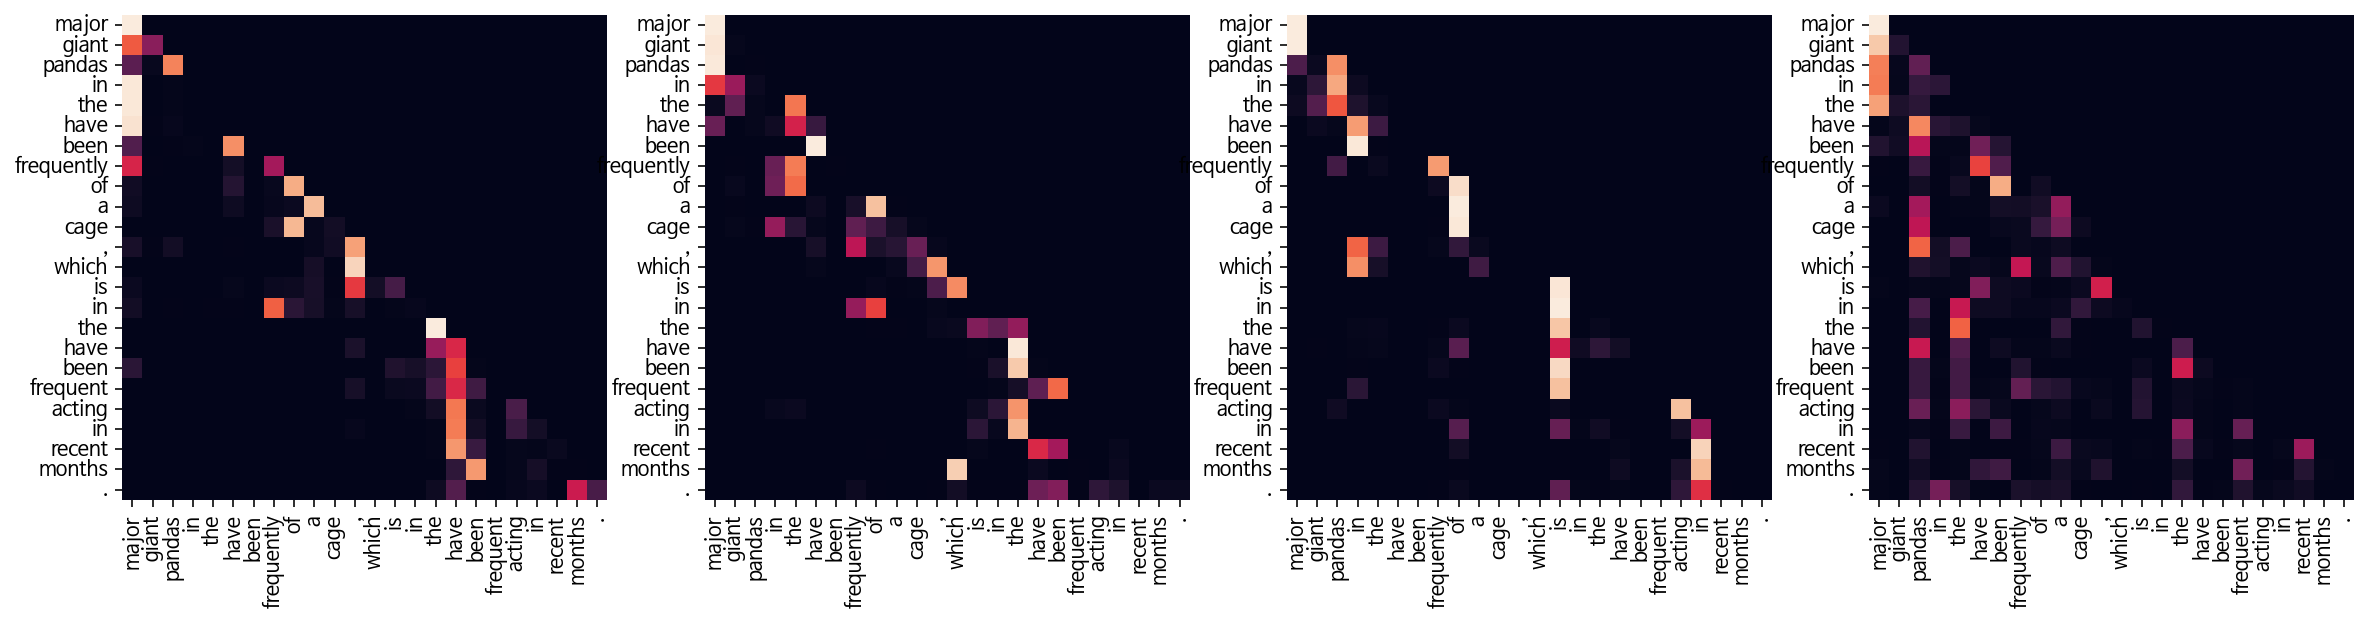

Decoder Src Layer 2


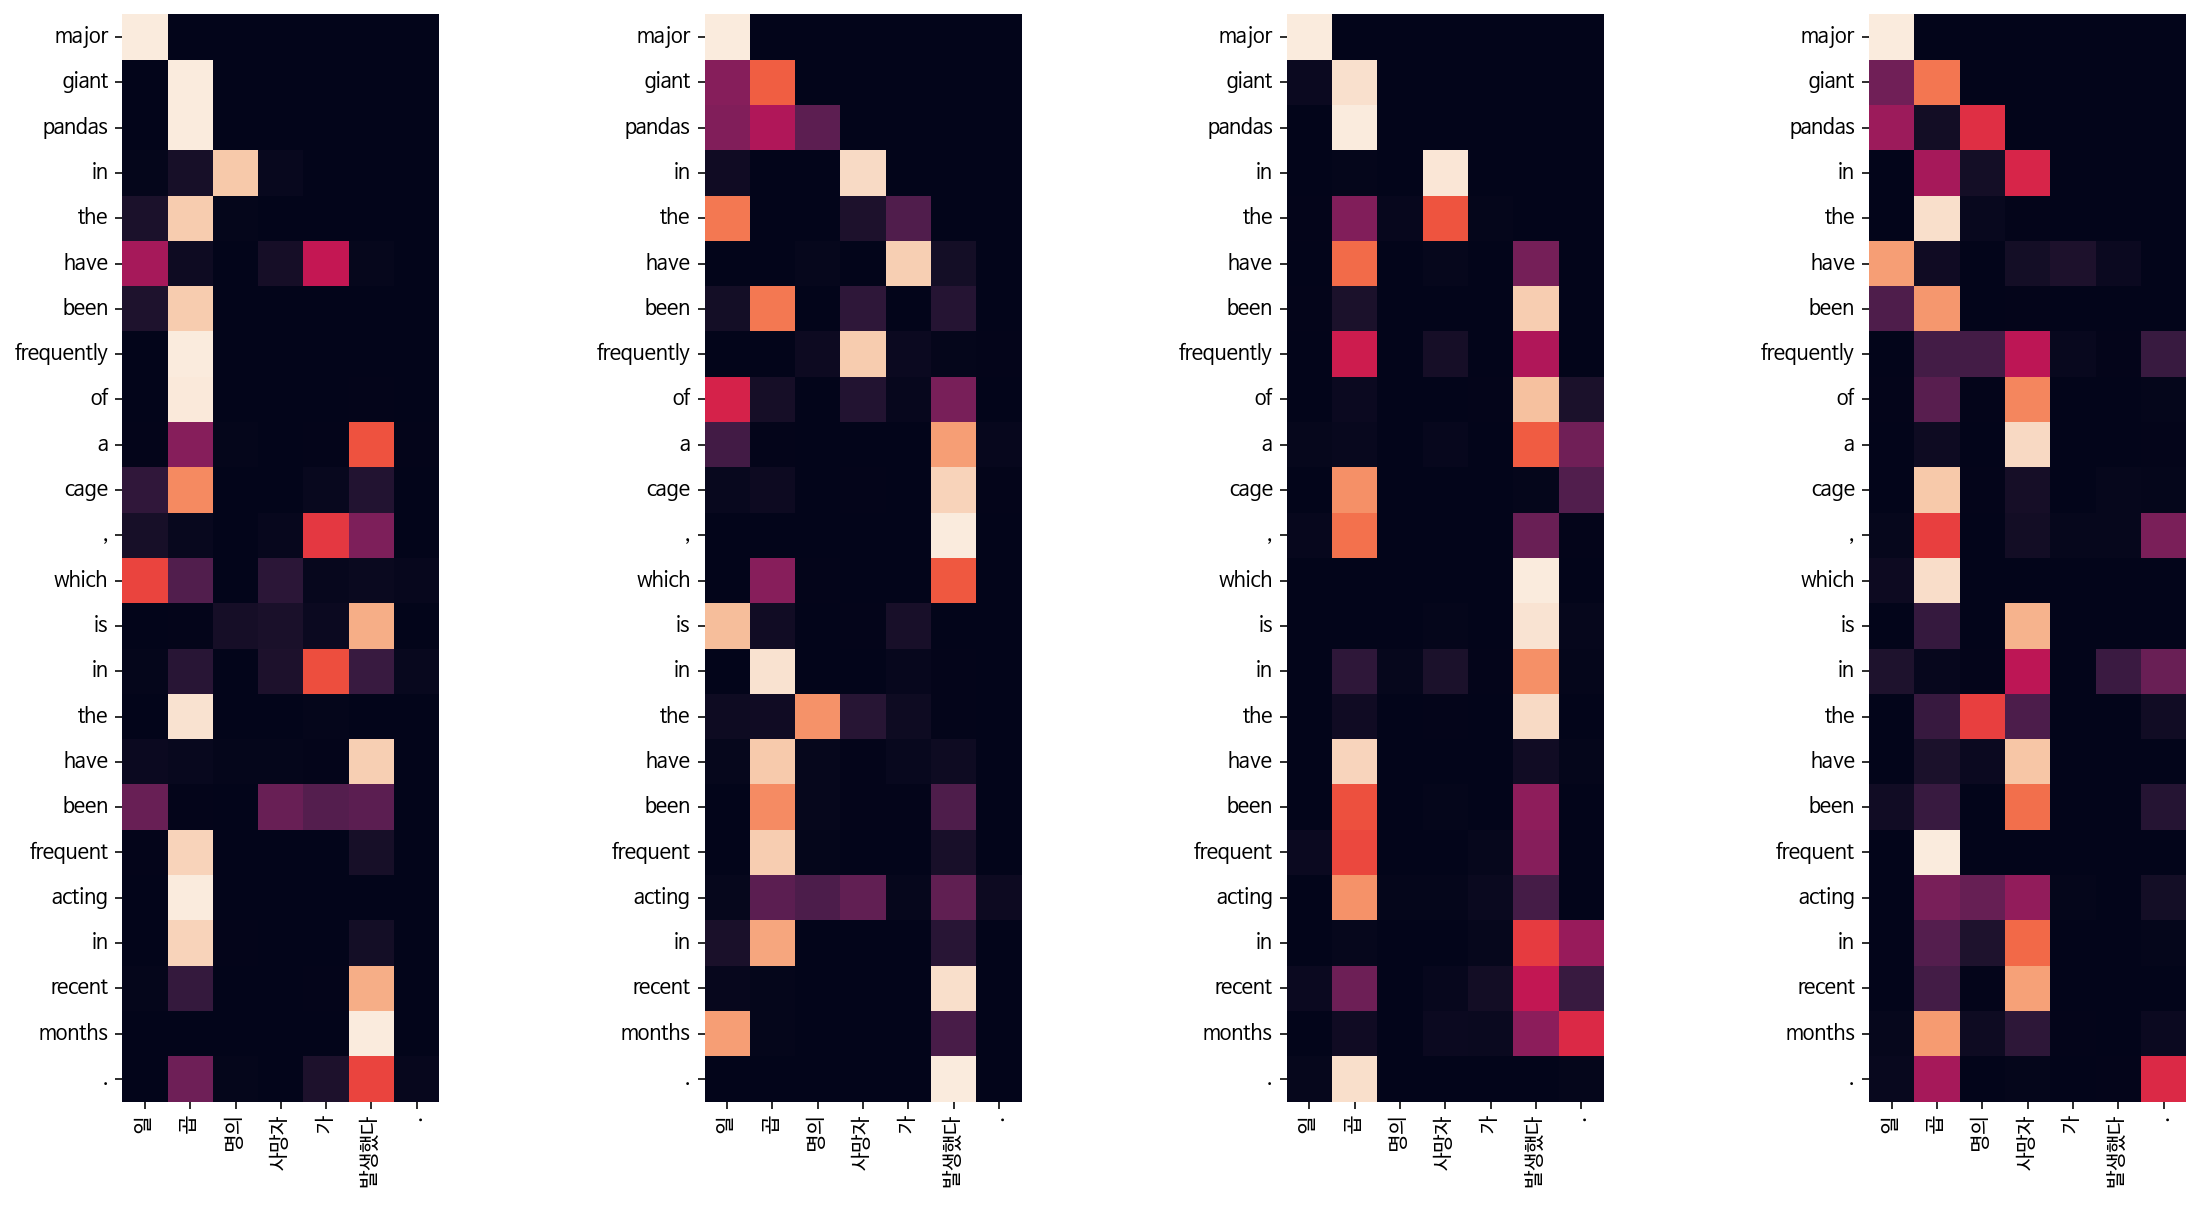

In [37]:
for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer, True)

In [43]:
transformer.save_weights('transformer_1.h5')